**Chapter 16 – Reinforcement Learning**

This notebook contains all the sample code and solutions to the exersices in chapter 16.

# Install Libs

In [2]:
#!pip install --upgrade pip
#!pip install --upgrade gym
#!pip install atari-py

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Note: there may be minor differences between the output of this notebook and the examples shown in the book. You can safely ignore these differences. They are mainly due to the fact that most of the environments provided by OpenAI gym have some randomness.

# Introduction to OpenAI gym

In this notebook we will be using [OpenAI gym](https://gym.openai.com/), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's start by importing `gym`:

Next we will load the MsPacman environment, version 0.

In [4]:
import gym

In [5]:
env = gym.make('MsPacman-v0')

Let's initialize the environment by calling is `reset()` method. This returns an observation:

In [6]:
obs = env.reset()

Observations vary depending on the environment. In this case it is an RGB image represented as a 3D NumPy array of shape [width, height, channels] (with 3 channels: Red, Green and Blue). In other environments it may return different objects, as we will see later.

In [7]:
obs.shape

(210, 160, 3)

An environment can be visualized by calling its `render()` method, and you can pick the rendering mode (the rendering options depend on the environment). In this example we will set `mode="rgb_array"` to get an image of the environment as a NumPy array:

In [8]:
img = env.render(mode="rgb_array")

Let's plot this image:

<IPython.core.display.Javascript object>


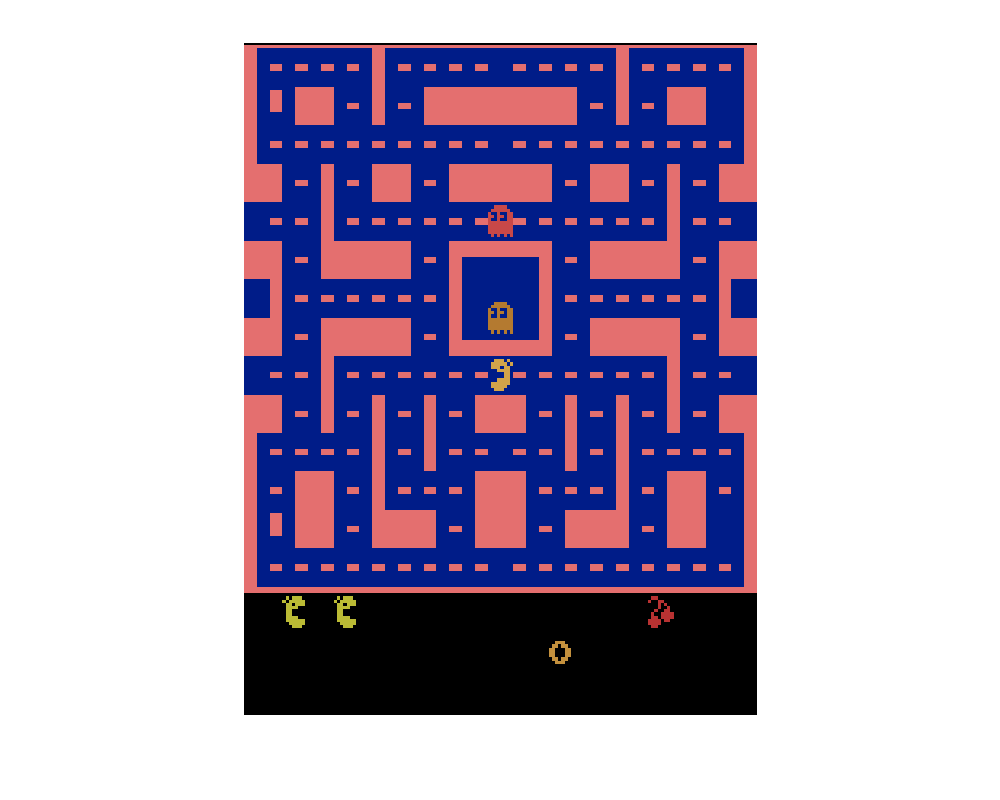

Saving figure MsPacman


In [9]:
plt.figure(figsize=(5,4))
plt.imshow(img)
plt.axis("off")
save_fig("MsPacman")
plt.show()

Welcome back to the 1980s! :)

In this environment, the rendered image is simply equal to the observation (but in many environments this is not the case):

In [10]:
(img == obs).all()

True

Let's create a little helper function to plot an environment:

In [11]:
def plot_environment(env, figsize=(5,4)):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

In [12]:
env.action_space

Discrete(9)

`Discrete(9)` means that the possible actions are integers 0 through 8, which represents the 9 possible positions of the joystick (0=center, 1=up, 2=right, 3=left, 4=down, 5=upper-right, 6=upper-left, 7=lower-right, 8=lower-left).

Next we need to tell the environment which action to play, and it will compute the next step of the game. Let's go left for 110 steps, then lower left for 40 steps:

In [13]:
env.reset()
for step in range(110):
    env.step(3) #left
for step in range(40):
    env.step(8) #lower-left

Where are we now?

<IPython.core.display.Javascript object>


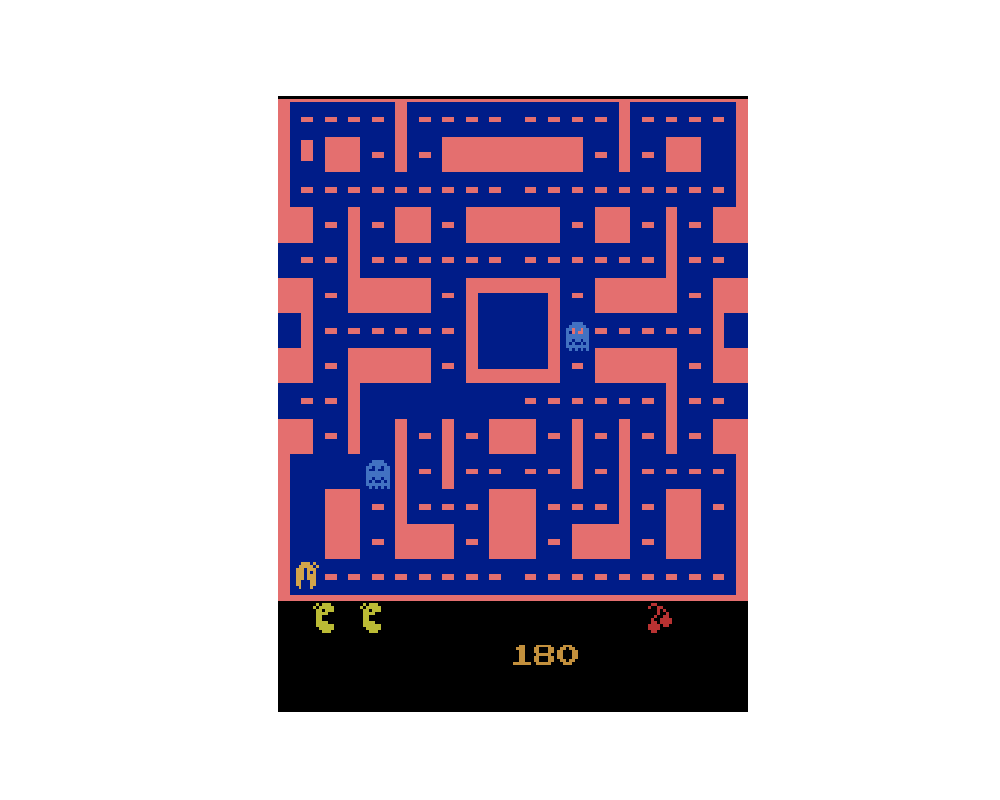

In [14]:
plot_environment(env)

The `step()` function actually returns several important objects:

In [15]:
obs, reward, done, info = env.step(0)

The observation tells the agent what the environment looks like, as discussed earlier. This is a 210x160 RGB image:

In [16]:
obs.shape

(210, 160, 3)

The environment also tells the agent how much reward it got during the last step:

In [17]:
reward

0.0

When the game is over, the environment returns `done=True`:

In [18]:
done

False

Finally, `info` is an environment-specific dictionary that can provide some extra information about the internal state of the environment. This is useful for debugging, but your agent should not use this information for learning (it would be cheating).

In [19]:
info

{'ale.lives': 3}

Let's play one full game (with 3 lives), by moving in random directions for 10 steps at a time, recording each frame:

In [20]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode="rgb_array")
    frames.append(img)
    if step % n_change_steps == 0:
        action = env.action_space.sample() # play randomly
    obs, reward, done, info = env.step(action)
    if done:
        break

Now show the animation (it's a bit jittery within Jupyter):

In [21]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

<IPython.core.display.Javascript object>


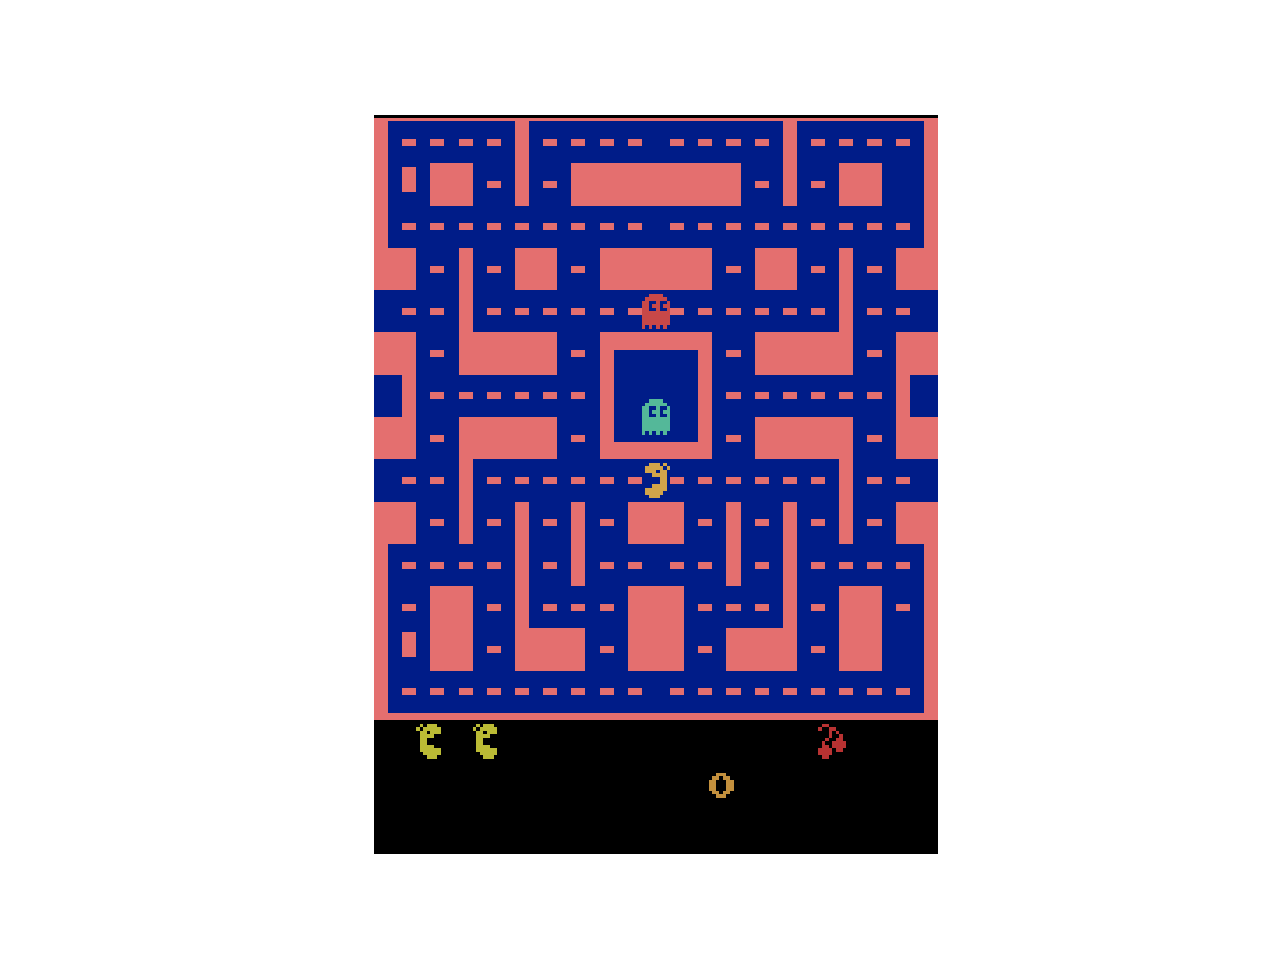

In [22]:
video = plot_animation(frames)
plt.show()

Once you have finished playing with an environment, you should close it to free up resources:

In [23]:
env.close()

To code our first learning agent, we will be using a simpler environment: the Cart-Pole. 

# A simple environment: the Cart-Pole

The Cart-Pole is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

In [24]:
# 创建CartPole-v0环境
env = gym.make("CartPole-v0")

In [25]:
# 初始化环境，返回的obs表示环境当前的观察报告
obs = env.reset()

In [26]:
# 对于CartPole-v0来说，观察报告包括（小推车水平位置(0.0是中心)，速度，杆的角度(0.0是90度)，杆的角速度)
obs

array([-0.00426607, -0.04212871,  0.01034618,  0.00748037])

The observation is a 1D NumPy array composed of 4 floats: they represent the cart's horizontal position, its velocity, the angle of the pole (0 = vertical), and the angular velocity. Let's render the environment... unfortunately we need to fix an annoying rendering issue first.

## Fixing the rendering issue

如果动画在Jupytor Notebook中不能正常显示，参考下面说明

Some environments (including the Cart-Pole) require access to your display, which opens up a separate window, even if you specify the `rgb_array` mode. In general you can safely ignore that window. However, if Jupyter is running on a headless server (ie. without a screen) it will raise an exception. One way to avoid this is to install a fake X server like Xvfb. You can start Jupyter using the `xvfb-run` command:

    $ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook

If Jupyter is running on a headless server but you don't want to worry about Xvfb, then you can just use the following rendering function for the Cart-Pole:

In [27]:
from PIL import Image, ImageDraw
try:
    # 尝试使用OpenAI的渲染函数
    # firstly try to use OpenAI gym's rendering function
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True
except Exception:
    # 使用系统自带的渲染函数，如果没有可用的X Server来开启OpenAI的渲染函数
    # probably no X server available, let's use our own rendering function
    openai_cart_pole_rendering = False
print("openai_cart_pole_rendering: ", openai_cart_pole_rendering)

openai_cart_pole_rendering:  False


In [28]:
# 渲染函数
def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # 使用OpenAI GYM自带的渲染函数
        return env.render(mode="rgb_array")
    else:
        # 自定义渲染 (OpenAI GYM渲染函数不可用时使用)
        # 配置参数
        img_w = 600                 # 显示区域宽度（像素值）
        img_h = 400                 # 显示区域高度（像素值）
        cart_w = img_w // 12        # 小车的宽度（像素值）
        cart_h = img_h // 15        # 校车的高度（像素值）
        pole_len = img_h // 3.5     # 杆子的高度（像素值）
        pole_w = img_w // 80 + 1    # 杆子的宽度（像素值）
        x_width = 2                 # 横坐标(宽度方向)刻度的宽度（像素值）
        max_ang = 0.2               # 杆子最大倾角
        bg_col = (255, 255, 255)    # 背景色
        cart_col = 0x000000         # 小车颜色（Blue Green Red）
        pole_col = 0x669acc         # 杆子颜色（Blue Green Red）
        # 环境观察报告
        pos, vel, ang, ang_vel = obs    #（小推车水平位置(0.0是中心)，速度，杆的角度(0.0是90度)，杆的角速度)
        # 部件坐标
        cart_x = pos * img_w // x_width + img_w // x_width          # 小车横坐标
        cart_y = img_h * 95 // 100                                  # 小车纵坐标 
        top_pole_x = cart_x + pole_len * np.sin(ang)                # 杆子顶部横坐标 
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)  # 杆子顶部纵坐标
        # 画图：背景，地面，小车，杆子
        img    = Image.new('RGB', (img_w, img_h), bg_col)
        draw   = ImageDraw.Draw(img)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

# 画图函数
def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

<IPython.core.display.Javascript object>


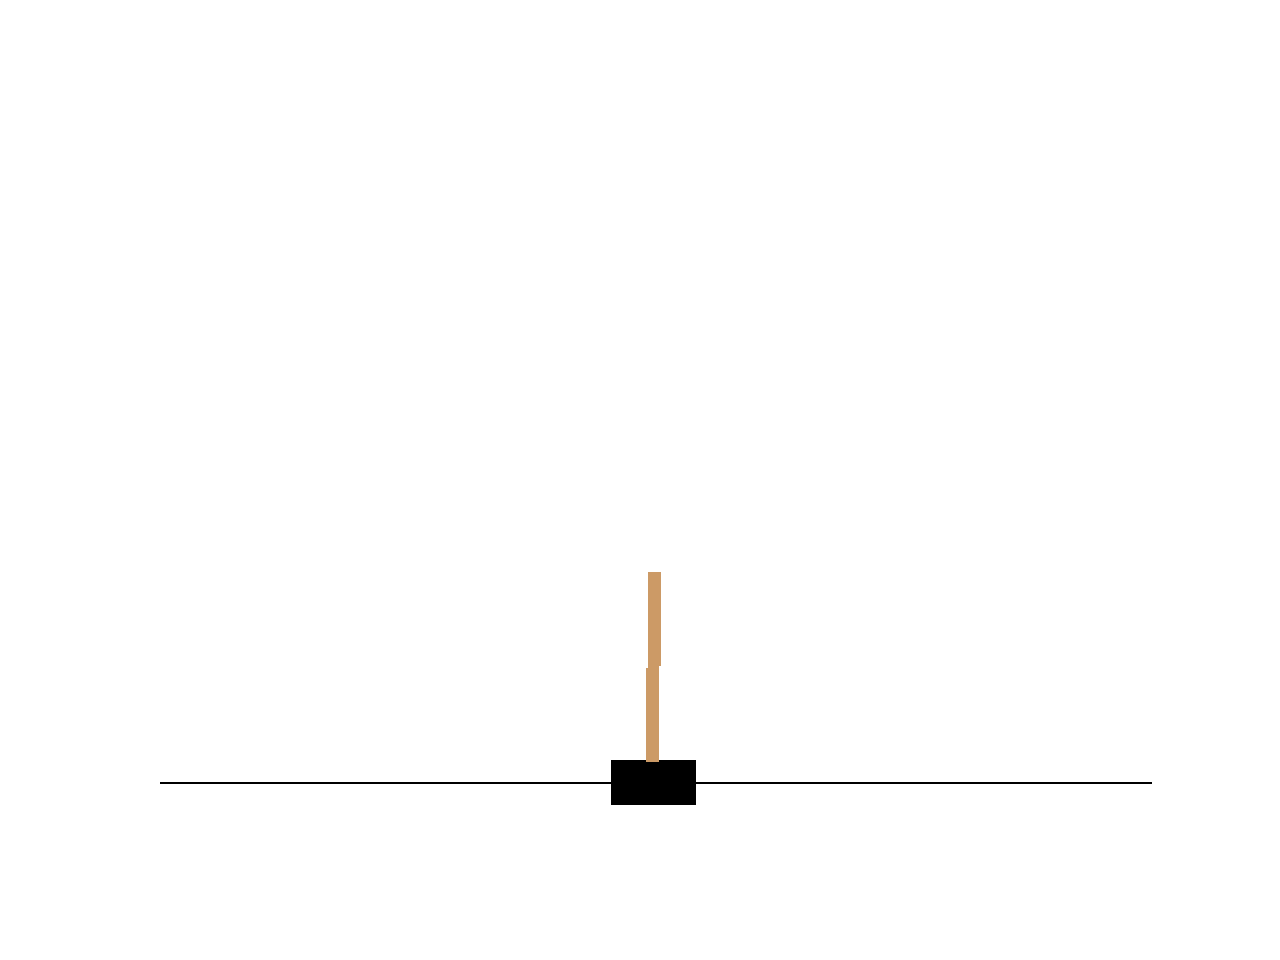

In [29]:
# 绘制初始化环境
plot_cart_pole(env, obs)

Now let's look at the action space:

In [30]:
# 查看这个支持哪些操作
# Discrete(2)表示支持两个操作: 0:向左加速; 1:向右加速
env.action_space

Discrete(2)

Yep, just two possible actions: accelerate towards the left or towards the right. Let's push the cart left until the pole falls:

In [31]:
# 模拟一个运行场景（每一步都向左加速）
obs = env.reset()
while True:
    # env.step(0): 向左加速; env.step(1):向右加速
    # 返回值：
    #   obs: 新的观测结果, 小推车水平位置(0.0是中心)，速度（大于0表示向右），杆的角度(0.0是90度，大于0表示右倾)，杆的角速度（大于0表示右加速)
    #   reward: 没做1步都会获得0.1的回报，目标是尽可能运行更长时间
    #   done: True表示实验结束
    #   info: 调试信息
    obs, reward, done, info = env.step(0)
    print(reward, done, obs, info)
    if done:
        break

1.0 False [-0.03412238 -0.21446573 -0.03814793  0.28874486] {}
1.0 False [-0.03841169 -0.40902351 -0.03237303  0.56915644] {}
1.0 False [-0.04659216 -0.60367682 -0.0209899   0.8514674 ] {}
1.0 False [-0.0586657  -0.7985064  -0.00396056  1.13747681] {}
1.0 False [-0.07463583 -0.99357633  0.01878898  1.42891501] {}
1.0 False [-0.09450735 -1.1889252   0.04736728  1.72741024] {}
1.0 False [-0.11828586 -1.38455552  0.08191549  2.03444736] {}
1.0 False [-0.14597697 -1.58042065  0.12260443  2.35131612] {}
1.0 False [-0.17758538 -1.77640922  0.16963075  2.67904765] {}
1.0 True [-0.21311356 -1.97232686  0.22321171  3.01833877] {}


<IPython.core.display.Javascript object>


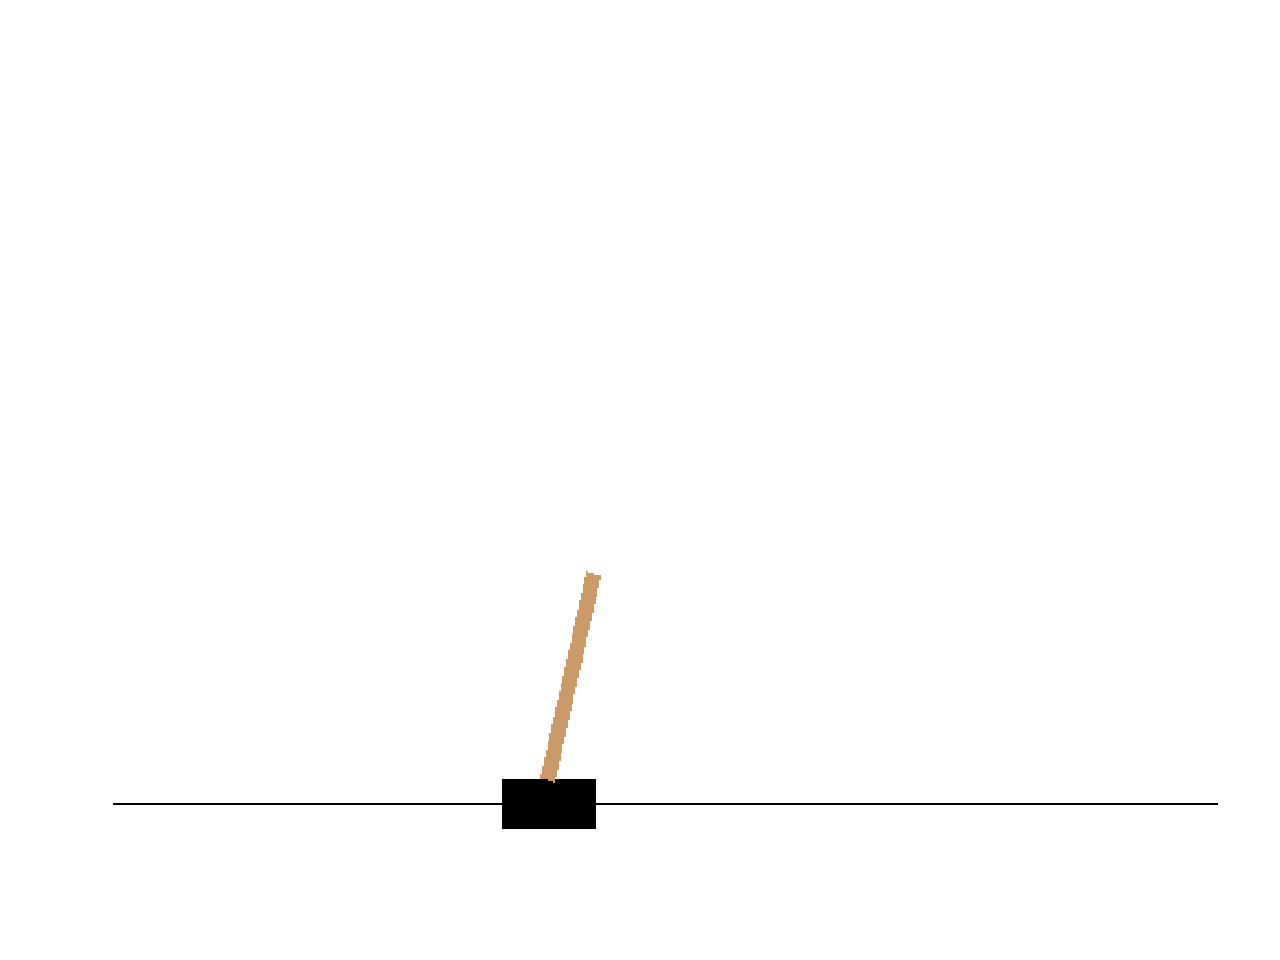

Saving figure cart_pole_plot


In [32]:
# 绘制上面场景结束时的状态
plt.close()  # or else nbagg sometimes plots in the previous cell
img = render_cart_pole(env, obs)
plt.imshow(img)
plt.axis("off")
save_fig("cart_pole_plot")

In [33]:
img.shape

(400, 600, 3)

Notice that the game is over when the pole tilts too much, not when it actually falls. Now let's reset the environment and push the cart to right instead:

In [34]:
# 模拟一个运行场景（每一步都向右加速）
obs = env.reset()
while True:
    obs, reward, done, info = env.step(1)
    if done:
        break
    print(reward, done, obs, info)

1.0 False [-0.02841567  0.21510771  0.00109293 -0.31715362] {}
1.0 False [-0.02411352  0.41021408 -0.00525014 -0.60949168] {}
1.0 False [-0.01590924  0.60540902 -0.01743997 -0.9038236 ] {}
1.0 False [-0.00380106  0.80076279 -0.03551645 -1.20193678] {}
1.0 False [ 0.0122142   0.99632559 -0.05955518 -1.50553561] {}
1.0 False [ 0.03214071  1.19211725 -0.08966589 -1.81620132] {}
1.0 False [ 0.05598305  1.3881151  -0.12598992 -2.13534348] {}
1.0 False [ 0.08374536  1.5842393  -0.16869679 -2.4641411 ] {}


<IPython.core.display.Javascript object>


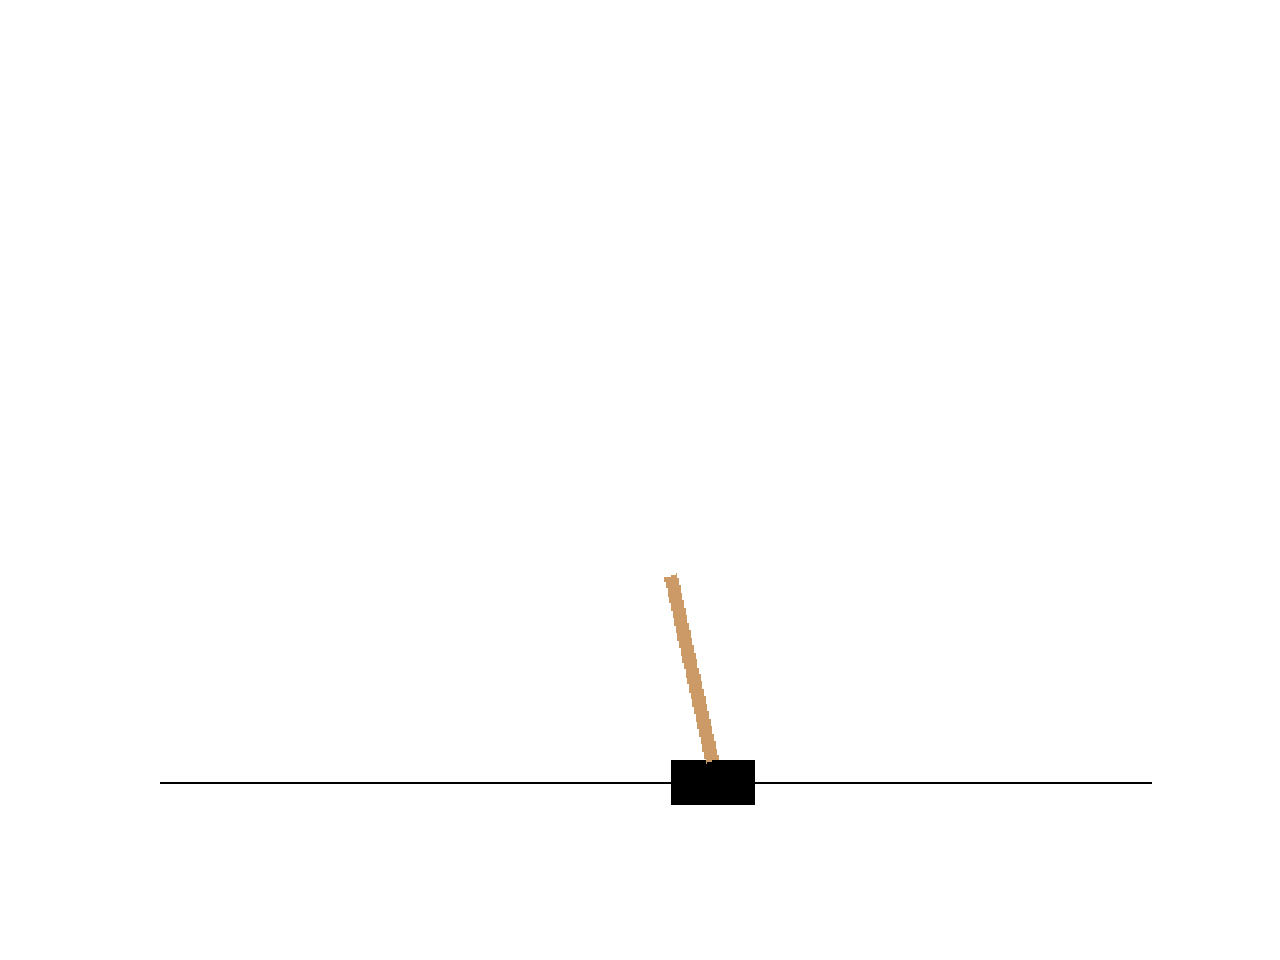

In [35]:
plot_cart_pole(env, obs)

Looks like it's doing what we're telling it to do. Now how can we make the poll remain upright? We will need to define a _policy_ for that. This is the strategy that the agent will use to select an action at each step. It can use all the past actions and observations to decide what to do.

# A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and _vice versa_. Let's see if that works:

In [36]:
# 不使用policy，hard code的策略

# 最终录到视频中的动画帧
frames = []

# 参数
n_max_steps = 1000
n_change_steps = 10

# 运行最多1000步
obs = env.reset()
for step in range(n_max_steps):
    # 渲染当前画面，并添加到动画帧中
    img = render_cart_pole(env, obs)
    frames.append(img)
    # 获得当前的环境报告：小车水平位置(0.0是中心)，速度（大于0表示向右），杆的角度(0.0是90度，大于0表示右倾)，杆的角速度（大于0表示右加速)
    position, velocity, angle, angular_velocity = obs
    # 执行下一步操作：杆倾角偏左则让小车向左加速，杆倾角偏右则让小车向右加速，
    if angle < 0:
        action = 0
    else:
        action = 1
    # 检查执行操作后，是否触发游戏停止
    obs, reward, done, info = env.step(action)
    if done:
        break

# 查看总共维持了多少步
print(len(frames))

50


<IPython.core.display.Javascript object>


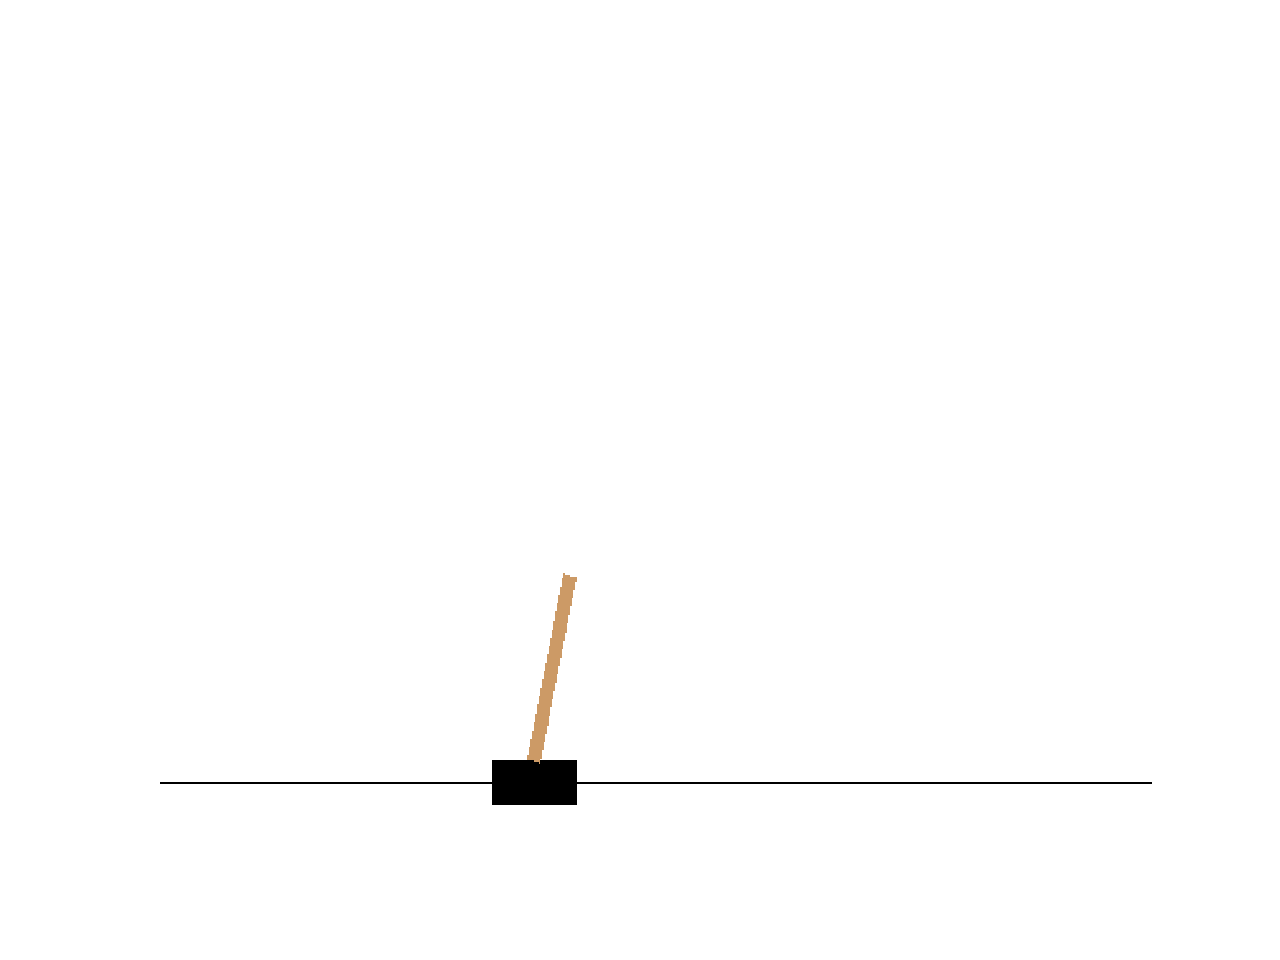

In [37]:
# 回放运行过程
video = plot_animation(frames)
plt.show()

Nope, the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

# Neural Network Policies

**使用神经网络来操作小车**

**方法：**神经网络从环境中获取输入，预算每种操作的正确概率，作为输出**

**输出：**CartPole只有两种输出（向左加速，向右加速），因此只需要一个输出神经元，该神经元输出值p为向左加速操作的正确概率，则1-p是向右加速的正确概率

**输入：**CartPole的环境比较简单，只需要考虑当前的环境（小车水平位置(0.0是中心)，速度（大于0表示向右），杆的角度(0.0是90度，大于0表示右倾)，杆的角速度（大于0表示右加速），使用4个输入神经元

**注意有些环境包含隐藏状态，需要考虑过去的行为和观察，下面是两个例子：**

1. 例如：环境只包含了车的位置，没有车的速度，需要根据过去两个时间点的环境观察来估算车速

2. 例如：环境观察存在噪音，需要根据多个环境观察来估算当前环境观察的数据

**操作：**根据输出层的概率值来随机选择操作，按概率随机、既可以参考模型输出，同时也给神经网络探索新行为的机会

Let's create a neural network that will take observations as inputs, and output the action to take for each observation. To choose an action, the network will first estimate a probability for each action, then select an action randomly according to the estimated probabilities. In the case of the Cart-Pole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability `p` of the action 0 (left), and of course the probability of action 1 (right) will be `1 - p`.

Note: instead of using the `fully_connected()` function from the `tensorflow.contrib.layers` module (as in the book), we now use the `dense()` function from the `tf.layers` module, which did not exist when this chapter was written. This is preferable because anything in contrib may change or be deleted without notice, while `tf.layers` is part of the official API. As you will see, the code is mostly the same.

The main differences relevant to this chapter are:
* the `_fn` suffix was removed in all the parameters that had it (for example the `activation_fn` parameter was renamed to `activation`).
* the `weights` parameter was renamed to `kernel`,
* the default activation is `None` instead of `tf.nn.relu`

In [38]:
import tensorflow as tf

# 1. 神经网络结构：4个输入层神经元对应当前环境的4个变量，1个输出层神经元对应向左加速的正确概率，隐藏层神经元只有4个因为任务简单不易使用复杂网络
n_inputs  = 4  # == env.observation_space.shape[0]
n_hidden  = 4  # it's a simple task, we don't need more than this
n_outputs = 1  # only outputs the probability of accelerating left

# 2. 构建神经网络
# 权重初始化(initializer): 用于缓解梯度消失和梯度爆炸问题
#        https://www.w3cschool.cn/tensorflow_python/tensorflow_python-e9tb2ocq.html
#        使用默认参数: 
#           distribution = "normal" (样本从以0为中心的截断正态分布中抽取, 使用stddev = sqrt(scale / n))
#           mode =“fan_in” (用于计算stddev的n为权重张量中输入单元的数量)
#           scale=1.0
# 输出层：使用sigmoid激活函数、是为了把隐藏层的输出值映射成[0,1]之间的单一概率（这里建模成了二分类问题，如果是多分类问题需要用softmax激活函数（）
# 隐藏层：使用elu激活函数，用于缓解梯度消失问题
initializer = tf.variance_scaling_initializer()
X           = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden      = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
outputs     = tf.layers.dense(hidden, n_outputs, activation=tf.nn.sigmoid, kernel_initializer=initializer)

# 3. 根据输出层输出的概率值随机选择操作
# tf.multinomial(logits, num_samples, seed=None, name=None)
#     从多项式分布中抽取样本，：https://www.w3cschool.cn/tensorflow_python/tensorflow_python-l5d12fln.html
#     logits：形状为 [batch_size, num_classes] 的二维张量；每个切片：[i, :] 表示所有类的非标准化对数概率
#     num_samples: 0维张量.为每行切片绘制的独立样本数
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs]) # (left_prop, right_prop = 1 - leftprop)
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1) 

# 4.  初始化全局变量
init = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.random.categorical instead.


In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

You may wonder why we are picking a random action based on the probability given by the policy network, rather than just picking the action with the highest probability. This approach lets the agent find the right balance between _exploring_ new actions and _exploiting_ the actions that are known to work well. Here's an analogy: suppose you go to a restaurant for the first time, and all the dishes look equally appealing so you randomly pick one. If it turns out to be good, you can increase the probability to order it next time, but you shouldn't increase that probability to 100%, or else you will never try out the other dishes, some of which may be even better than the one you tried.

Let's randomly initialize this policy neural network and use it to play one game:

In [39]:
# 目前的模型还没有训练（权重都是随机的），先简单跑通，让模型能够操作小车，随后再训练模型
n_max_steps = 1000
frames = []
with tf.Session() as sess:
    init.run()
    obs = env.reset() # 环境的初始变量值
    for step in range(n_max_steps):
        img = render_cart_pole(env, obs) # 渲染小车画面
        frames.append(img)               # 添加到动画帧中
        action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)}) # 将当前环境喂给模型，得到预估的操作值
        obs, reward, done, info = env.step(action_val[0][0])  # 执行该操作，得到新的环境变量值
        if done:
            break
            
# 不要忘记关闭环境
env.close()

Now let's look at how well this randomly initialized policy network performed:

<IPython.core.display.Javascript object>


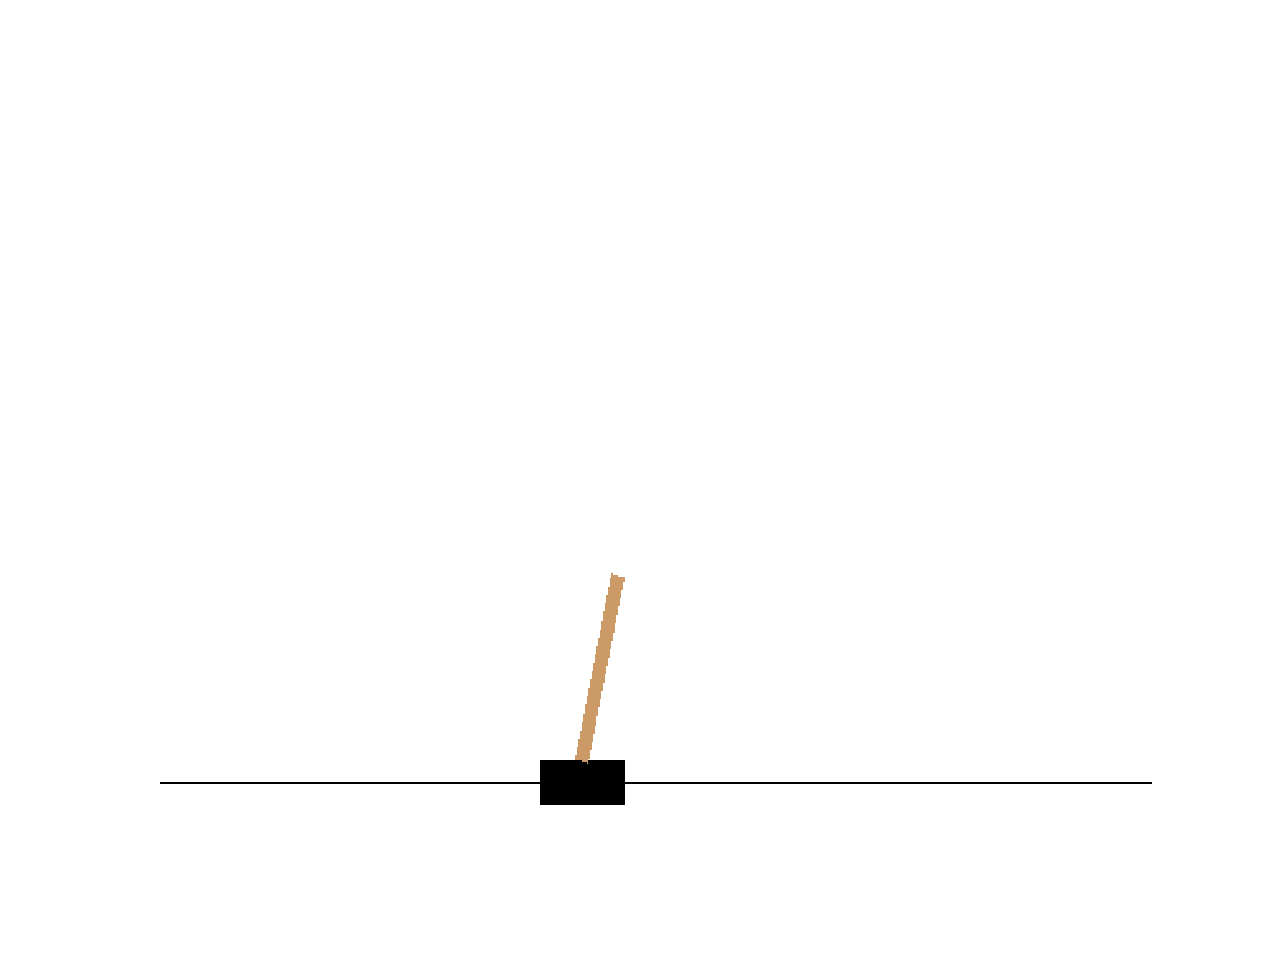

In [40]:
# 播放动画帧
video = plot_animation(frames)
plt.show()

Yeah... pretty bad. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right. The following code defines the same neural network but we add the target probabilities `y`, and the training operations (`cross_entropy`,  `optimizer` and `training_op`):

**强化学习模型训练的难点在于如何给出正确的样本标注（Y值：棋谱）**

下一个版本再探讨这个问题，这一版采用一个非常简单直白的样本标注，即

* 车杆左倾斜时，Y标为左加速操作

* 车杆右倾斜时，Y标为右加速操作

将数据喂给神经网络之后，模型可以学到类似的操作行为（车杆左倾时左加速、右倾时右加速），当然这还不足以让小车运行很长时间

In [41]:
import tensorflow as tf

In [42]:
# 重置数据流图
reset_graph()

# 数据流图参数
n_inputs  = 4         # 输入层4个神经元对应环境观察的4个变量
n_hidden  = 4         # 简单问题，使用简单神经网络，隐藏层4个神经元
n_outputs = 1         # 建模为
learning_rate = 0.01  # 梯度下降的学习率

# X是当前环境观察值，Y是当前操作的“棋谱”标注（车杆左倾时标为左加速、车杆右倾时标为右加速）
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])

# 构造3层神经网络
initializer = tf.variance_scaling_initializer() # 按正态分布初始化模型权重
hidden  = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer) #隐藏层
logits  = tf.layers.dense(hidden, n_outputs)    # logits输出层，只有1个神经元，激活函数设为None以便在下一步手动计算outputs
outputs = tf.nn.sigmoid(logits)                 # 用sigmoid作为激活函数，将logits值映射为[0,1]区间的概率值

# 使用从多项式分布中、按权重概率随机的方法决定action（左加速、右加速）
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action           = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

# 使用logits与标签y的交叉熵作为优化目标梯度下降
cross_entropy    = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer        = tf.train.AdamOptimizer(learning_rate)
training_op      = optimizer.minimize(cross_entropy)

init   = tf.global_variables_initializer()
saver  = tf.train.Saver()

We can make the same net play in 10 different environments in parallel, and train for 1000 iterations. We also reset environments when they are done.

In [43]:
n_environments = 10
n_iterations = 1000

envs = [gym.make("CartPole-v0") for _ in range(n_environments)]
observations = [env.reset() for env in envs]

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        # obs = [小车水平位置(0.0是中心)，速度（大于0表示向右），杆的角度(0.0是90度，大于0表示右倾)，杆的角速度（大于0表示右加速)]
        # 用车杆的倾角作为Y值，车杆左倾时Y=1(等于左加速操作的op_id)，车杆右倾时Y=0(等于左加速操作的op_id)
        # if angle<0 we want proba(left)=1., or else proba(left)=0.
        target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations]) 
        # X值是环境的观测值
        # Y值是模型操作的标记值（车杆左倾时op标记为左加速，车杆右倾时op标记为右加速）
        action_val, _ = sess.run([action, training_op], feed_dict={X: np.array(observations), y: target_probas})
        # 从1000个环境中提取数据进行训练
        for env_index, env in enumerate(envs):
            # 再每个game environment中，不断操作直到game over
            obs, reward, done, info = env.step(action_val[env_index][0])
            observations[env_index] = obs if not done else env.reset()
    # 保存session
    saver.save(sess, "./my_policy_net_basic.ckpt")

for env in envs:
    env.close()

In [44]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames        

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_policy_net_basic.ckpt


<IPython.core.display.Javascript object>


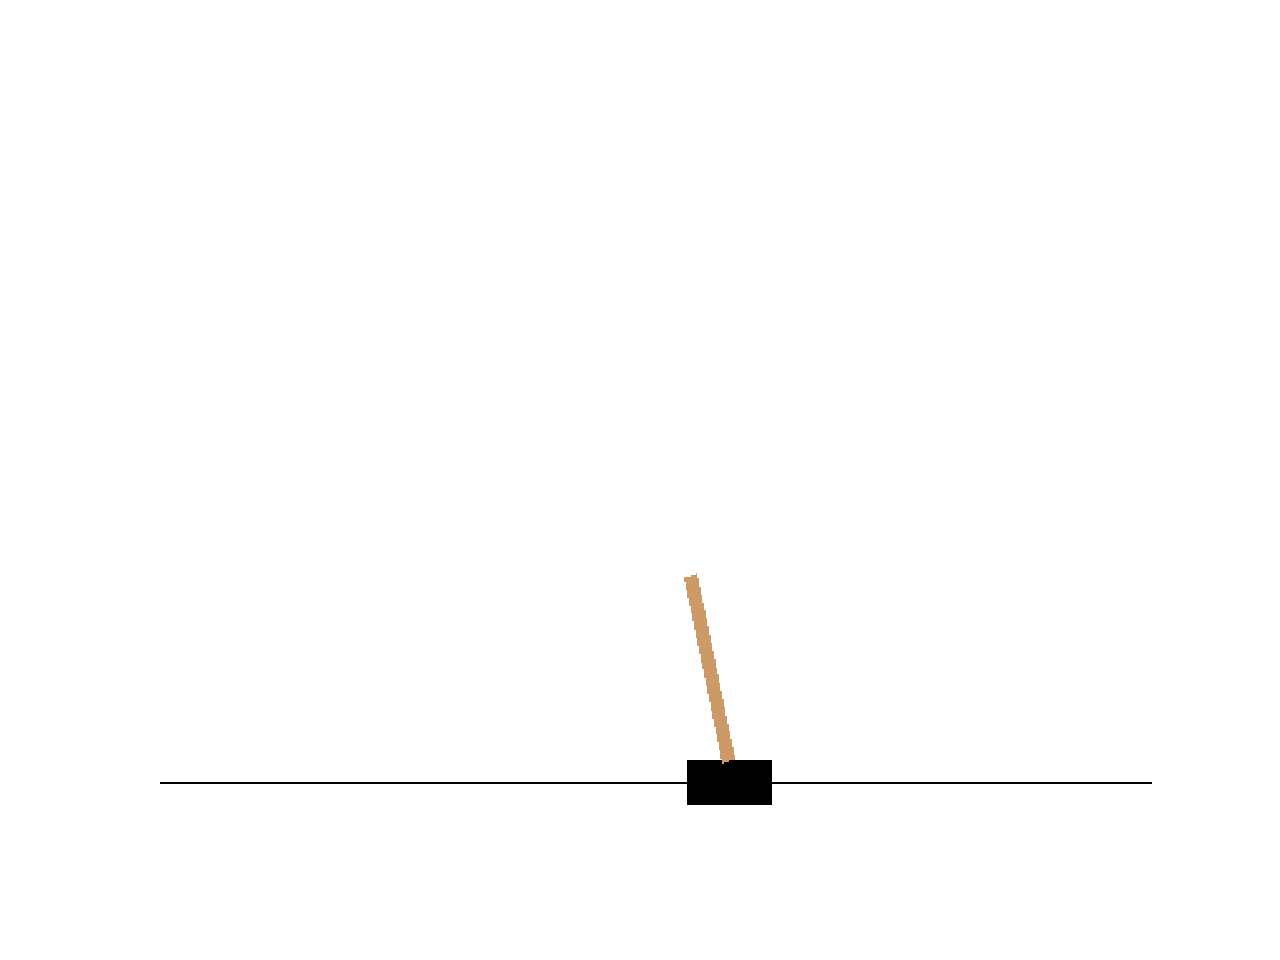

In [45]:
# 从动画演示中可以看出，模型学到了车杆左倾时左加速、车杆右倾时右加速的行为，但是不足以让小车运行很长时间
frames = render_policy_net("./my_policy_net_basic.ckpt", action, X)
video = plot_animation(frames)
plt.show()

Looks like it learned the policy correctly. Now let's see if it can learn a better policy on its own.

# Policy Gradients （策略梯度）

**用策略梯度训练以让小车尽可能运行更长时间的模型**

**常规监督学习的问题:** 
* 常规监督学习最小化预估概率和目标(样本标签)概率之间的交叉熵来学习
* 在强化学习场景中，代理获得指导(样本标签)的唯一方法是通过回报，但是回报通常是稀疏和延迟的（例如操作100步之后小车的杆子倒了、无法知道是这100步中的哪几步导致杆子倾倒）

**用信用分配来解决回报稀疏和延迟的问题:**根据回报的总和来评估一个行为，即在每步之后乘以一次折扣率r（通常r取值为0.95或0.99）

* 例子
    * 代理决定在某个位置决定未来的3步连续执行三次右加速，折扣系数r=0.8
    * 未来的3步得到的回报分别是：+20, 0, -50
    * 那么在这个位置代理所做决定的回报值是 20*0.8 + 0 - 50*0.8<sup>2</sup> = -22
* 通常r取值为0.95或0.99
    * r = 0.95时，第13步时回报的折扣为0.5 （即0.95^13 = 0.5)
    * r = 0.99时，第69步时回报的折扣为0.5 （即0.99^69 = 0.5)

**一个好的操作可能在很多不好的操作后执行，碰巧遇到杆子倒掉，导致好的行为得到低的分数** 

* 解决这个问题的办法是：实验足够多次数，即让游戏运行很多遍，将所有的行为得分归一化（通过减去平均值并除以标准偏差）

**设个算法简单、但是非常强大，可以解决更复杂的问题。实际上，AlphaGo就是基于类似的PG算法（加上蒙特卡罗树搜索）**

To train this neural network we will need to define the target probabilities `y`. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in a game, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the _credit assignment problem_.

The _Policy Gradients_ algorithm tackles this problem by first playing multiple games, then making the actions in good games slightly more likely, while actions in bad games are made slightly less likely. First we play, then we go back and think about what we did.

In [46]:
import tensorflow as tf

# 重置数据流图
reset_graph()

# 模型参数
n_inputs  = 4  # 对应环境观察的4个变量
n_hidden  = 4  # 简单问题、隐藏层神经元不宜太多
n_outputs = 1  # 建模为2分类

learning_rate = 0.01 # 学习率
initializer = tf.variance_scaling_initializer() # 按某种正态分布初始化模型权重来对抗梯度消失和梯度爆炸

# 模型数据流图：输入层X；隐藏层；输出层(logits，以及根据logits计算出的action)
X       = tf.placeholder(tf.float32, shape=[None, n_inputs])  # X是一个batch的环境观察值（形状是[None, n_inputs]) //？？？
hidden  = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer) # 隐藏层
logits  = tf.layers.dense(hidden, n_outputs) # 单个神经元的logits层、为隐藏层输出的线性表达式，这里激活函数留空(None)在下一步设置
outputs = tf.nn.sigmoid(logits)              # 使用sigmod函数、将logits输出的浮点数映射为[0,1]区间的概率值，即向左加速的正确概率
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs]) # [向左加速的正确概率，向右加速的正确概率]
action  = tf.multinomial(tf.log(p_left_and_right), num_samples=1)   # 根据多项式分布概率值随机选取操作

# 目标概率(y值)，行为(action)向左加速时目标概率设为1.0，行为(action)向右加速时目标概率设为0.0
y       = 1. - tf.to_float(action) 

# 计算预测值(sigmoid_with_logits(logits))与目标值之间的交叉熵
# 使用compute_gradients没使用minimize_gradients是因为希望能有机会在apply之前调整梯度
cross_entropy  = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer      = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy) 

# grads_and_vars是数组，元素是<grad, var>即梯度与变量(模型参数)对，每个模型参数有一个梯度，
gradients = [grad for grad, variable in grads_and_vars]

# 从gradients到gradient_placeholders这个位置是断开的
# 要到数据流图执行时，使用信用分配+rewards均值归一化来从多轮游戏的运行结果中计算

# 用来表示梯度的占位符，使用占位符，会在数据流图执行（后面的代码）时，有机会在apply之前调整梯度(乘以行为得分、归一化、计算调整后的均值)
gradient_placeholders = [] # 格式：grad[]
grads_and_vars_feed   = [] # 格式：grad_and_var<grad[], variable>[]
for grad, variable in grads_and_vars:
    print(variable)        # 变量的形状，后面执行数据流图计算梯度时会用到
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))

# 在数据流图被执行时，上面的代码块将整个batch的X所计算给出的梯度都收集到一起
# 因此apply的是
training_op = optimizer.apply_gradients(grads_and_vars_feed)

# 初始化全局变量以及模型序列化模块
init  = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.cast instead.
<tf.Variable 'dense/kernel:0' shape=(4, 4) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(4,) dtype=float32_ref>
<tf.Variable 'dense_1/kernel:0' shape=(4, 1) dtype=float32_ref>
<tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32_ref>


In [47]:
# 执行数据流图时会用到的函数

# 计算总折扣：返回与rewards长度相同的float数组
# 计算方法：对于越
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

# 计算回报
def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean  = flat_rewards.mean()
    reward_std   = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [48]:
# 测试discount_rewards函数
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

**<p>discount_rewards</p>**
<p>input: rewards = [10, 0, -50]</p>
<p>ouput: discount_reward = [-22 = 10+0*0.8<sup>1</sup>-50*0.8<sup>2</sup>,  -40 = 0-50*0.8<sup>1</sup>, -50]</p>

In [49]:
# 验证discount_and_normalize_rewards函数是否符合设计的初衷
def discount_and_normalize_rewards_with_log(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    print("all_rewards:", all_rewards)
    print("all_discounted_rewards:", all_discounted_rewards)
    print("flat_rewards:", flat_rewards)
    print("reward_mean:", reward_mean)
    print("reward_std:", reward_std)
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]
discount_and_normalize_rewards_with_log([[10, 0, -50], [10, 20]], discount_rate=0.8)

all_rewards: [[10, 0, -50], [10, 20]]
all_discounted_rewards: [array([-22., -40., -50.]), array([26., 20.])]
flat_rewards: [-22. -40. -50.  26.  20.]
reward_mean: -13.2
reward_std: 30.947697814215523


[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

从上面的计算结果可以看出，第一次实验结果严重差于第二次实验结果，所有action都被认为是不好的，而第二次所有action都认为是好的
discount_and_normalize_rewards返回了我们期望的结果

**<p>discount_and_normalize_rewards</p>**
1. 输入rewards: 格式为float[][]
2. discounted_rewards: 将rewards中所有的float[]转换为discount之后的float（使用上一个函数discount_rewards）
3. flat_rewards: 数组拼接成一个，用来求均值(reward_mean)和标准差(reward_std)
4. 为discounted_rewards中的每一个float做归一化（减去均值再除以标准差）

In [70]:
# 执行数据流图、训练模型

# 初始化env
env = gym.make("CartPole-v0")

# 模型训练参数
n_iterations       = 250   # 训练250轮（对于小车出界问题处理不好，训练750轮会改善出界的问题）
n_games_per_update = 10    # 每轮10次游戏（10个epsisodes）都运行之后，使用discount_and_normalize_rewards()计算得分更新梯度
n_max_steps        = 1000  # 每次游戏最多执行1000步，避免模型无休止运行下去
save_iterations    = 10    # 每训练10轮(10*10=100次游戏)，保存一次模型
discount_rate      = 0.95  # 折扣率：0.95时，操作在第13步的回报的折扣为0.5(即0.95^13 = 0.5)；0.99时，第69步时回报的折扣为0.5

# 执行数据流图
with tf.Session() as sess:
    init.run()
    # 运行250轮训练
    for iteration in range(n_iterations):
        # 打印当前论数
        print("\rIteration: {}".format(iteration), end="")
        # 多轮游戏的rewards和gradients
        all_rewards   = [] #格式 reward_float[game_idx][step_idx]
        all_gradients = [] #格式 gradients[game_idx][step_idx][variable_idx]
        # 每轮训练运行10次游戏
        for game in range(n_games_per_update):
            # 单轮游戏的rewards[]和gradients
            current_rewards = []
            current_gradients = []
            # 每次游戏最多执行1000步，防止游戏无休止运行
            obs = env.reset()
            for step in range(n_max_steps):
                # 对数据流图上半段的action和gradients求值，得到基于当前环境观察预测出的action及模型变量梯度
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                # 在游戏中执行action，更新环境观测值
                obs, reward, done, info = env.step(action_val[0][0])
                # 将当前的rewards和gradients存入数组
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                # Game Over
                if done:
                    break
            # append整轮游戏的rewards[step_idx]，gradients[step_idx][variable_idx]
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
        # 计算折扣、均值、正则化之后的rewards[game_idx][step_idx][var_index] = reward[gsv]
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            # 计算一个var的grient，并赋值给对应的gradient_placeholder
            # 喂给np.mean(*, axis=0)的数据形状是data[game_idx][step_idx]，没有var_idx它在内循环中是定值
            mean_input = np.array([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)])
            mean_gradients = np.mean(mean_input, axis=0)
            # print(mean_input.shape, mean_gradients.shape) #np.mean(*,axis=0)在第一根轴上求均值
            # (293, 4, 4) -> (4, 4)
            # (293, 4)    -> (4,)
            # (293, 4, 1) -> (4, 1)
            # (293, 1)    -> (1,)
            # print(variable) # 前面创建数据流图时，打印的4个variable的形状
            # <tf.Variable 'dense/kernel:0' shape=(4, 4) dtype=float32_ref>   #输入层到隐藏层的连接权重 
            # <tf.Variable 'dense/bias:0' shape=(4,) dtype=float32_ref>       #输入层到隐藏层的偏置权重
            # <tf.Variable 'dense_1/kernel:0' shape=(4, 1) dtype=float32_ref> #隐藏层到输出层的连接权重
            # <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32_ref>     #隐藏层到输出层的偏置权重
            feed_dict[gradient_placeholder] = mean_gradients
        # 对模型下半段的training_op求职，来进行梯度下降
        sess.run(training_op, feed_dict=feed_dict)
        # 每训练10轮保存一次模型
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_policy_net_pg.ckpt")

Iteration: 249

In [50]:
# 演示一下np.mean(raw, axis=0)的用途
raw  = np.array([[[1,2,3,4],[5,6,7,8],[9,10,11,12]],[[1,2,3,4],[5,6,7,8],[9,10,11,12]]])
test = np.mean(np.array([raw,raw,raw,raw,raw]), axis=0)
print(np.array([raw,raw,raw,raw,raw]).shape, test.shape)

(5, 2, 3, 4) (2, 3, 4)


In [51]:
env.close()

INFO:tensorflow:Restoring parameters from ./my_policy_net_pg.ckpt


<IPython.core.display.Javascript object>


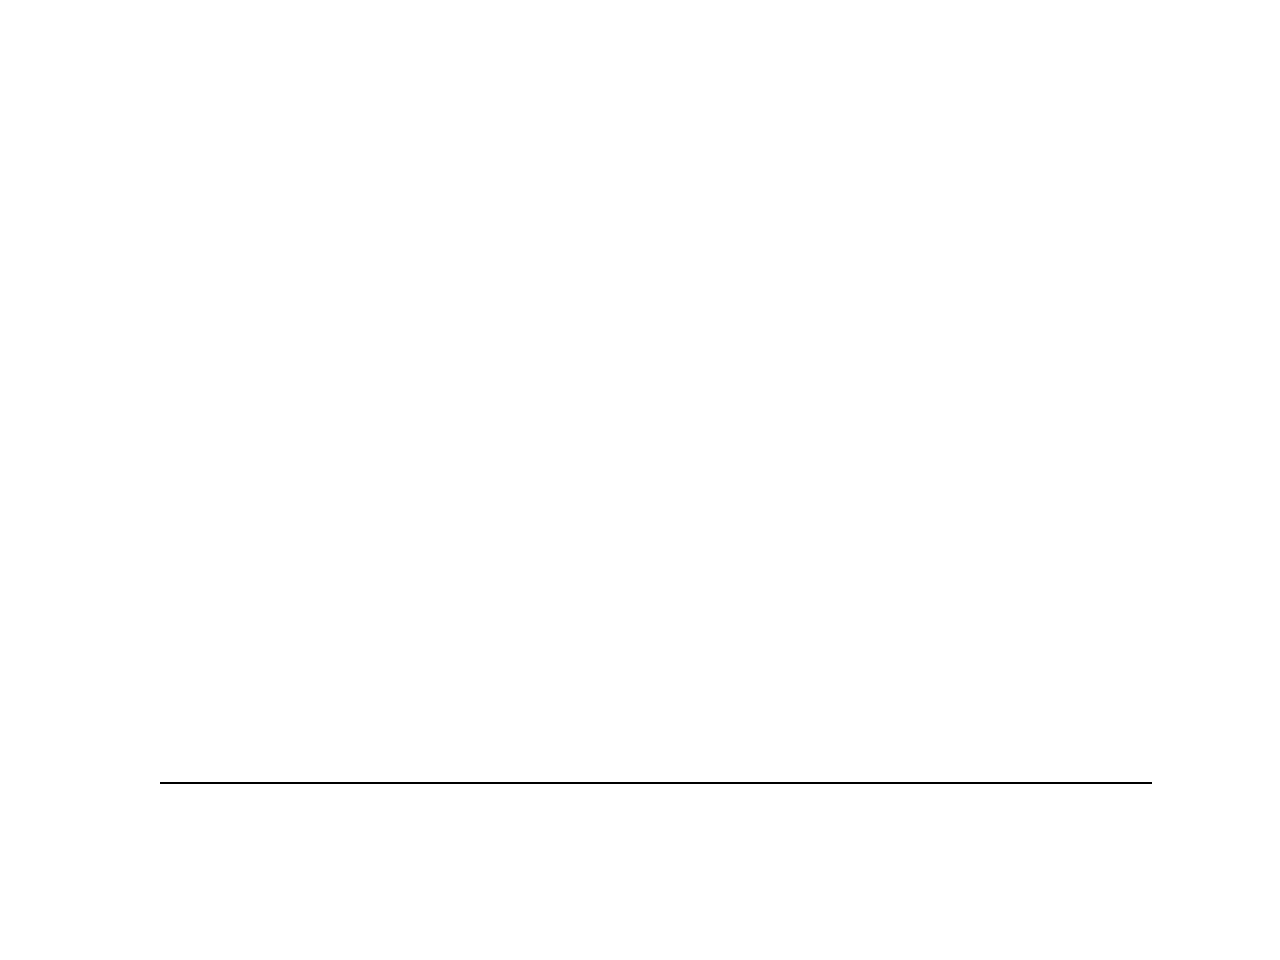

In [52]:
frames = render_policy_net("./my_policy_net_pg.ckpt", action, X, n_max_steps=1000)
video = plot_animation(frames)
plt.show()

# Markov Chains

用（状态转移概率）矩阵来表示马尔可夫链

In [53]:
# 状态转移概率，s是state的缩写
transition_probabilities = [
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to s0, s1, s2, s3
        [0.0, 1.0, 0.0, 0.0],  # from s2 to s0, s1, s2, s3
        [0.0, 0.0, 0.0, 1.0],  # from s3 to s0, s1, s2, s3
    ]

n_max_steps = 50

def print_sequence(start_state=0):
    current_state = start_state
    print("States:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        # 根据状态转移概率来随机选择下一个状态
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

States: 0 0 3 
States: 0 1 2 1 2 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
States: 0 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
States: 0 0 3 
States: 0 0 0 1 2 1 2 1 3 
States: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


# Markov Decision Process

用矩阵来表示马尔可夫决策过程

马尔可夫决策过程：状态 --(采取各种行动的概率)--> 行动 --((当前状态,行动)导致各种新状态的概率)--> 下一个状态(以及环境观测回报(即时回报))

矩阵：

1. 状态转移(T)矩阵：(当前状态,行动,新状态) -> 转移概率
2. 观测回报(R)矩阵：(当前状态,行动,新状态) -> 观测回报
3. 可选行动列表：状态 -> 可选行动列表

前提条件：
**使用MDP必须要满足一个前提条件，需要先验知识，即状态转移矩阵、观测回报矩阵必须已知**

In [54]:
# 状态转移(T)矩阵：(当前状态,行动,新状态) -> 转移概率
transition_probabilities = [
        # 当前状态1 -> 行动1[新状态1，2，3]，行动2[新状态1，2，3]，行动3[新状态1，2，3]
        # 当前状态2 -> 行动1[新状态1，2，3]，行动2[新状态1，2，3]，行动3[新状态1，2，3]
        # 当前状态3 -> 行动1[新状态1，2，3]，行动2[新状态1，2，3]，行动3[新状态1，2，3]
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]], # in s0, if action a0 then proba 0.7 to state s0 and 0.3 to state s1, etc.
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None],
    ]

# 观测回报(R)矩阵：(当前状态,行动,新状态) -> 观测回报
rewards = [
        # 当前状态1 -> 行动1[新状态1，2，3]，行动2[新状态1，2，3]，行动3[新状态1，2，3]
        # 当前状态2 -> 行动1[新状态1，2，3]，行动2[新状态1，2，3]，行动3[新状态1，2，3]
        # 当前状态3 -> 行动1[新状态1，2，3]，行动2[新状态1，2，3]，行动3[新状态1，2，3]    
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]],
    ]

# 可选的行动：状态 -> 可选行动列表
possible_actions = [[0, 1, 2], [0, 2], [1]]

# 选取容易遭受较大惩罚值的action
def policy_fire(state):
    # state是数组下标
    #   state=0时，action=0
    #   state=1时，action=2
    #   state=2时，action=1
    return [0, 2, 1][state] 

# 随机选取action
def policy_random(state):
    return np.random.choice(possible_actions[state])

# 选取容易得到回报的惩罚值
def policy_safe(state):
    return [0, 0, 1][state]

# 封装Markov Decision Process Environment
class MDPEnvironment(object):
    def __init__(self, start_state=0):
        self.start_state = start_state
        self.reset()
    def reset(self):
        self.total_rewards = 0
        self.state = self.start_state
    def step(self, action):
        # 选择state，根据<当前state, action>查概率表，按概率随机得到next state以及回reward
        next_state = np.random.choice(range(3), p=transition_probabilities[self.state][action])
        reward     = rewards[self.state][action][next_state]
        # 更新state，total_reward
        self.state = next_state
        self.total_rewards += reward
        # 返回
        return self.state, reward

# 运行一轮Markov Decision Process
def run_episode(policy, n_steps, start_state=0, display=True):
    env = MDPEnvironment()
    if display:
        # 前5轮输出
        print("States (+rewards):", end=" ") 
    for step in range(n_steps):
        # 每1轮前10步输出
        if display: 
            if step == 10:
                print("...", end=" ")
            elif step < 10:
                print(env.state, end=" ")
        # 根据policy选取action
        action = policy(env.state)
        # 查状态转换概率表，得到state和reward
        state, reward = env.step(action)
        if display and step < 10:
            if reward:
                print("({})".format(reward), end=" ")
    if display:
        print("Total rewards =", env.total_rewards)
    return env.total_rewards

for policy in (policy_fire, policy_random, policy_safe):
    all_totals = []
    print(policy.__name__)
    for episode in range(1000):
        all_totals.append(run_episode(policy, n_steps=100, display=(episode<5)))
    # 关注指标：平均回报，标准差，回报最小值，回报最大值
    print("Summary: mean={:.1f}, std={:1f}, min={}, max={}".format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
    print()

policy_fire
States (+rewards): 0 (10) 0 (10) 0 1 (-50) 2 2 2 (40) 0 (10) 0 (10) 0 (10) ... Total rewards = 210
States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 1 (-50) 2 2 (40) 0 (10) ... Total rewards = 70
States (+rewards): 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 70
States (+rewards): 0 1 (-50) 2 1 (-50) 2 (40) 0 (10) 0 1 (-50) 2 (40) 0 ... Total rewards = -10
States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) ... Total rewards = 290
Summary: mean=121.1, std=129.333766, min=-330, max=470

policy_random
States (+rewards): 0 1 (-50) 2 1 (-50) 2 (40) 0 1 (-50) 2 2 (40) 0 ... Total rewards = -60
States (+rewards): 0 (10) 0 0 0 0 0 (10) 0 0 0 (10) 0 ... Total rewards = -30
States (+rewards): 0 1 1 (-50) 2 (40) 0 0 1 1 1 1 ... Total rewards = 10
States (+rewards): 0 (10) 0 (10) 0 0 0 0 1 (-50) 2 (40) 0 0 ... Total rewards = 0
States (+rewards): 0 0 (10) 0 1 (-50) 2 (40) 0 0 0 0 (10) 0 (10) ... Total rewards = 40

# Q-Learning

<p>上面的MDP(Markov Decision Process)必须要满足一个前提条件，需要先验知识，即状态转移矩阵、观测回报矩阵必须已知</p>
<p>但实际上，在游戏初期代理并不知道转换概率、也不知道回报是什么</p>
<p>它必须经历完至少一次所有状态以及所有可能的转换、才能开始预估；通常要经历多次才能让这种预估变得准确</p>

**时间差分学习(Temporal difference Learning, TD)** 就是用来让代理在探索MDP的过程中学习状态转移概率（而不需要在初始时给出）

计算公式： V<sub>k+1</sub>(state) = (1 - alpha) * V<sub>k</sub>(s) + alpha * (reward + discount_rate * V<sub>k</sub>(state<sup>'</sup>))

其中：
* reward是代理观察到的回报值
* alpha是学习率超参数，开始时值比较高、随后逐渐减小让模型收敛

TD根据代理观测到的状态值、回报值来更新新的状态预估值；

对每个状态s，TD简单第持续跟踪代理离开该状态时获得的即时回报均值，加上期望以后得到的回报，**但是并没有考虑所采取的action以及那种action回报最高**

**Q学习：在TD的基础上，从“跟踪状态”细化到“跟踪<状态,action>“，即** 
* 用Q<sub>k</sub>(state, action)替换TD公式中的V<sub>k</sub>(state)
* 用max(Q<sub>k</sub>(s<sup>'</sup>, a<sup>'</sup>)替换公式中的V<sub>k</sub>(state<sup>'</sup>)

计算公式： Q<sub>k+1</sub>(state, action) = (1 - alpha) * Q<sub>k</sub>(state, action) + alpha * (reward + discount_rate * max(Q<sub>k</sub>(s<sup>'</sup>, a<sup>'</sup>))

对每一个<state, action>，算法持续跟踪代理通过行为action离开状态state时的平均回报，同时加上以后的期望回报

由于目标策略会采取最佳行为，因此对下一个状态采用最大的Q预估值

**TD和Q学习都不需要先验的状态转移矩阵、观测回报矩阵，只需要知道每个state下容许采取哪些action就够了**

**下面的Q学习代码，在给定足够的迭代数时，会收敛到最优的Q值**

Q-Learning works by watching an agent play (e.g., randomly) and gradually improving its estimates of the Q-Values. Once it has accurate Q-Value estimates (or close enough), then the optimal policy consists in choosing the action that has the highest Q-Value (i.e., the greedy policy).

In [55]:
n_states  = 3      # state数量3
n_actions = 3      # action数量3
n_steps   = 20000  # 探索20000步
alpha     = 0.01   # 学习率0.01
discount  = 0.99   # reward折扣0.99

# 采用随机选择action的策略
exploration_policy = policy_random

# 初始化Q值（其实就是<state, action>回报值）： 
# 不在possible_actions内的<state,action>初始化为负无穷，其余的初始化为0
q_values = np.full((n_states, n_actions), -np.inf) 
for state, actions in enumerate(possible_actions):
    q_values[state][actions]=0

# 初始化游戏环境
env = MDPEnvironment()

# 运行20000步
for step in range(n_steps):
    # 根据当前state所容许的action列表随机选action
    action = exploration_policy(env.state)
    state  = env.state
    # 执行action，根据MDP设定转换到下一个state，并获取代理观测到的reward
    next_state, reward = env.step(action)
    # 查表，选择Q值最大的action（greedy policy），在初始阶段Q值都是0
    next_value = np.max(q_values[next_state])
    # 因为代理观测到了reward，可以使用Q学习的公式更新<state,action>的Q值
    q_values[state, action] = (1-alpha)*q_values[state, action] + alpha*(reward + discount * next_value)

In [56]:
# 运行足够多次之后可以收敛（用随机选取action的策略，可以学到q_values矩阵）
q_values

array([[39.13508139, 38.88079412, 35.23025716],
       [18.9117071 ,        -inf, 20.54567816],
       [       -inf, 72.53192111,        -inf]])

In [57]:
# 测试一下学习到的q_values矩阵，根据矩阵中学到的回报预估值来选择action
def optimal_policy(state):
    return np.argmax(q_values[state])

In [58]:
# 测试结果显示，用q_values矩阵的数据来选择action，可以得到较高的rewards
all_totals = []
for episode in range(1000):
    all_totals.append(run_episode(optimal_policy, n_steps=100, display=(episode<5)))
print("Summary: mean={:.1f}, std={:1f}, min={}, max={}".format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
print()

States (+rewards): 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 1 (-50) 2 (40) 0 (10) ... Total rewards = 230
States (+rewards): 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 2 1 (-50) 2 (40) 0 (10) ... Total rewards = 90
States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 170
States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... Total rewards = 220
States (+rewards): 0 1 (-50) 2 (40) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) ... Total rewards = -50
Summary: mean=125.6, std=127.363464, min=-290, max=500



# Learning to Play MsPacman Using the DQN Algorithm

**Warning**: Unfortunately, the first version of the book contained two important errors in this section.

1. The actor DQN and critic DQN should have been named _online DQN_ and _target DQN_ respectively. Actor-critic algorithms are a distinct class of algorithms.
2. The online DQN is the one that learns and is copied to the target DQN at regular intervals. The target DQN's only role is to estimate the next state's Q-Values for each possible action. This is needed to compute the target Q-Values for training the online DQN, as shown in this equation:

$y(s,a) = \text{r} + \gamma . \underset{a'}{\max} \, Q_\text{target}(s', a')$

* $y(s,a)$ is the target Q-Value to train the online DQN for the state-action pair $(s, a)$.
* $r$ is the reward actually collected after playing action $a$ in state $s$.
* $\gamma$ is the discount rate.
* $s'$ is the state actually reached after played action $a$ in state $s$.
* $a'$ is one of the possible actions in state $s'$.
* $Q_\text{target}(s', a')$ is the target DQN's estimate of the Q-Value of playing action $a'$ while in state $s'$.

I hope these errors did not affect you, and if they did, I sincerely apologize.

## Creating the MsPacman environment

In [59]:
# 载入PacMan游戏
env = gym.make("MsPacman-v0")
obs = env.reset()
obs.shape

(210, 160, 3)

In [60]:
# 一共有9种操作
env.action_space 

Discrete(9)

## Preprocessing

Preprocessing the images is optional but greatly speeds up training.

In [61]:
# 对图片预处理，压缩到88*80像素，颜色转成灰度图，同时增加对比度，灰度值正则化到[-128, 127]
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2]                # crop and downsize
    img = img.sum(axis=2)                  # to greyscale
    img[img==mspacman_color] = 0           # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

Note: the `preprocess_observation()` function is slightly different from the one in the book: instead of representing pixels as 64-bit floats from -1.0 to 1.0, it represents them as signed bytes (from -128 to 127). The benefit is that the replay memory will take up roughly 8 times less RAM (about 6.5 GB instead of 52 GB). The reduced precision has no visible impact on training.

<IPython.core.display.Javascript object>


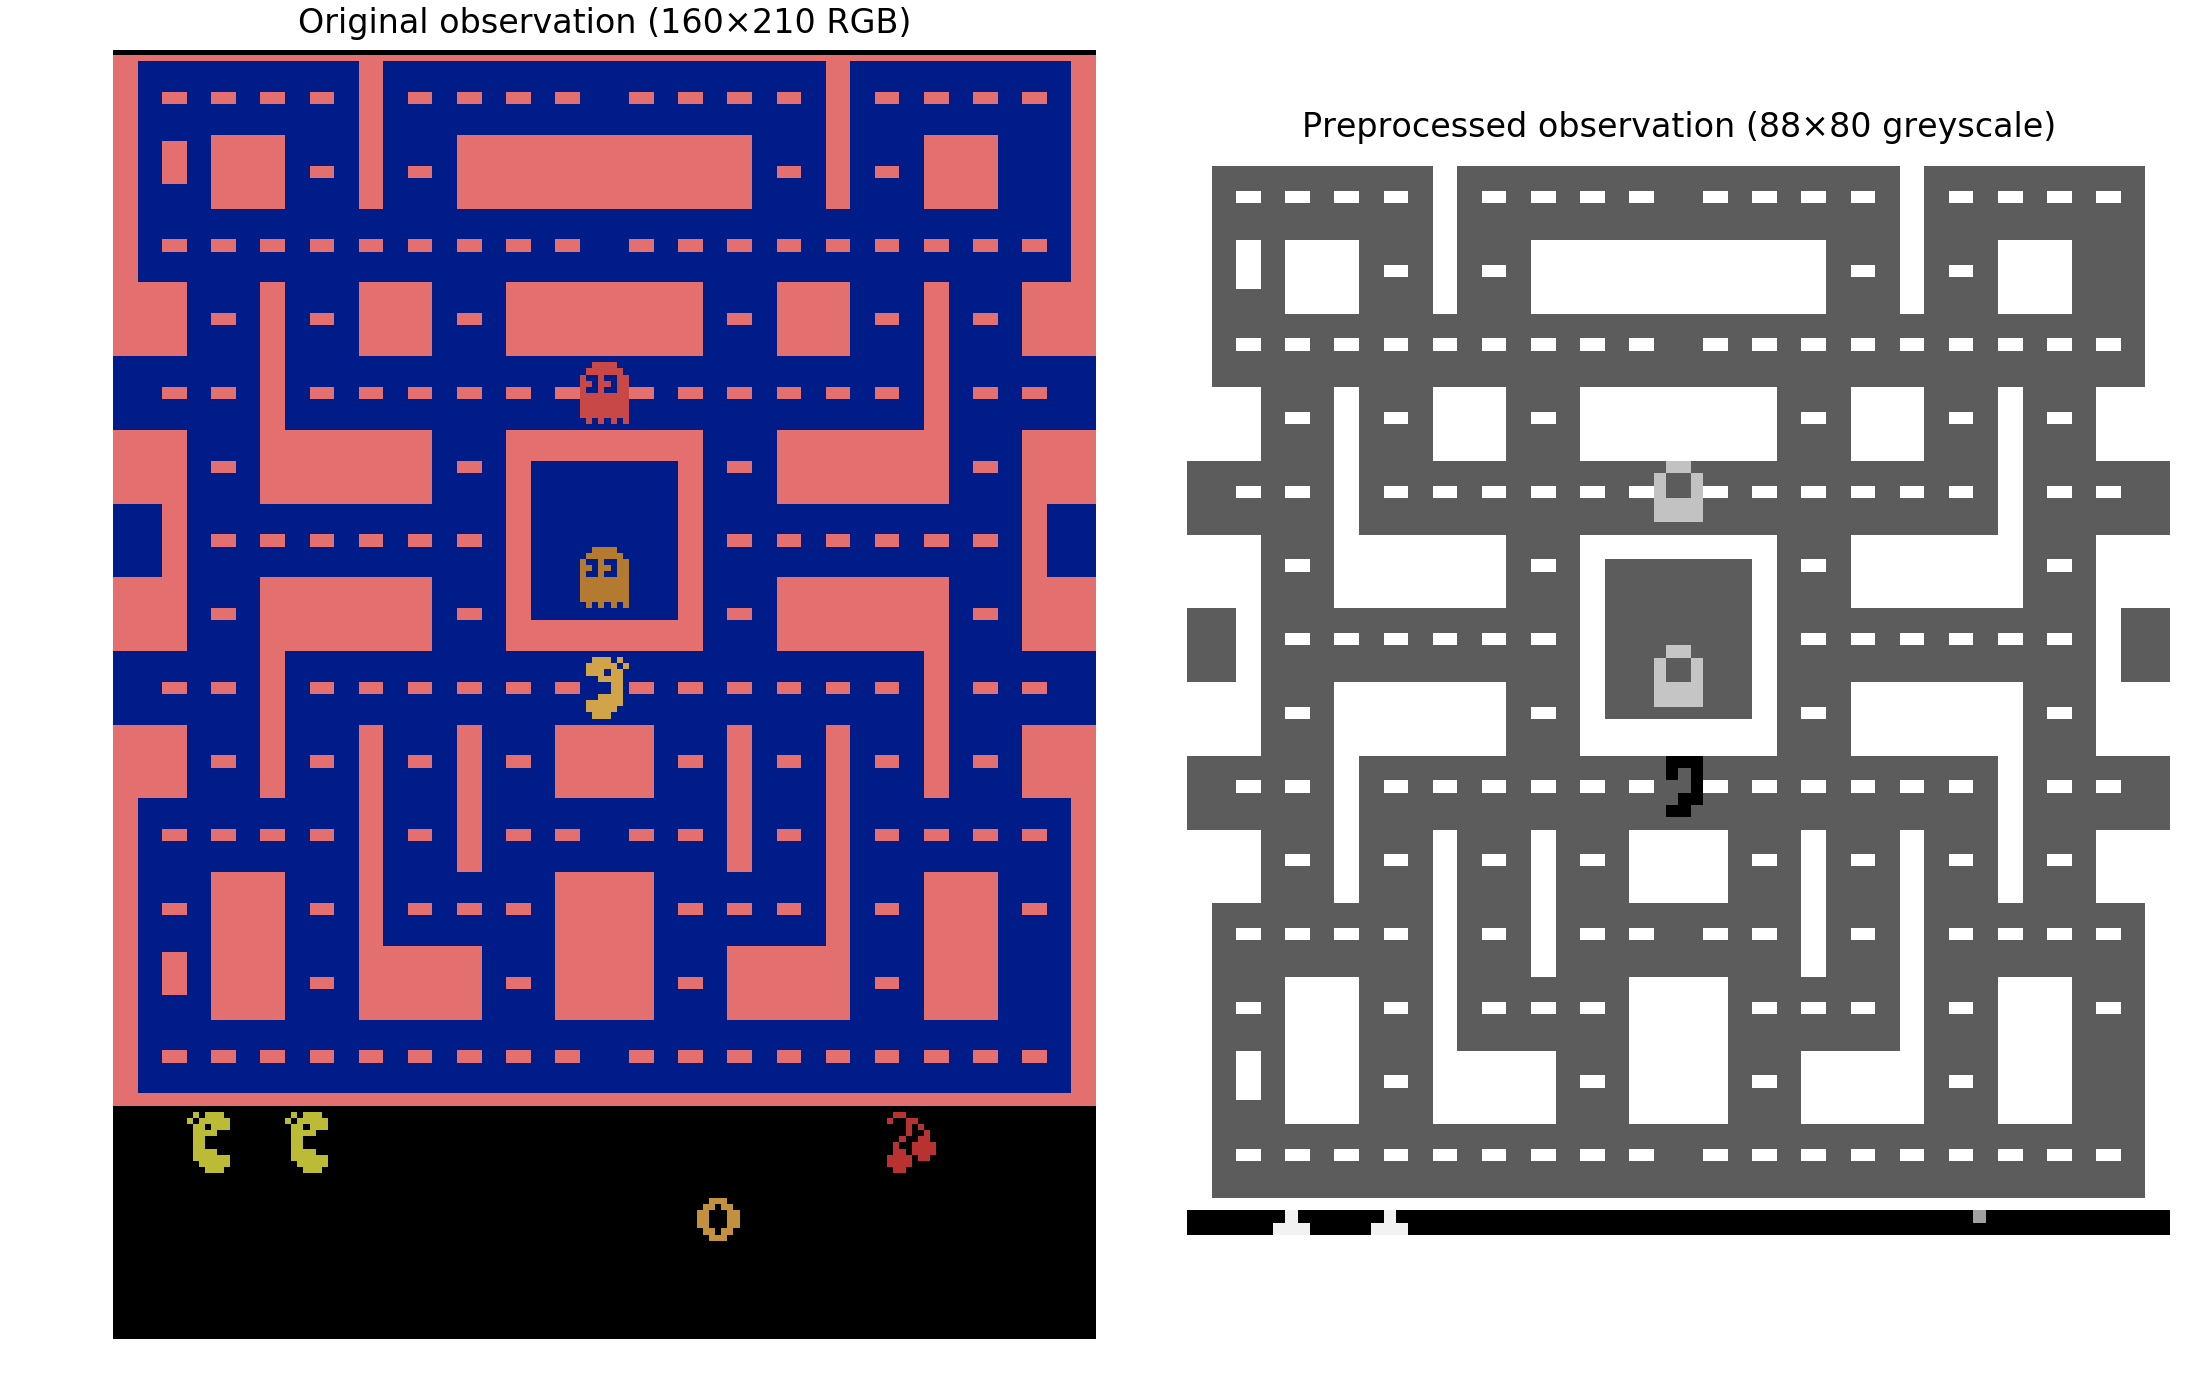

Saving figure preprocessing_plot


In [62]:
# 演示图片处理效果
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (88×80 greyscale)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
save_fig("preprocessing_plot")
plt.show()

## Build DQN (Deep Q Network)

-----

**Q学习的问题是：** 

* 需要维护大量的<state, action -> q_value>，对于大型（甚至中型）的MDP计算量过大
* 即时是吃豆人这样的游戏，250颗豆子，每种豆子有存在和被吃两种状态，所有可能的状态数大于2<sup>250</sup> = 10<sup>75</sup>，比可观察到的宇宙原子还要多

**逼近Q学习：**

解决上面问题的办法是使用可接受的参数数量，找到一个能够逼近Q值的函数，这就是**逼近Q学习**

**传统的逼近Q学习：**

从状态提取的手工特征的线性组合（例如，最接近幽灵的距离及方向等）来估计Q值

**DQN（Deep Q Network）：**

DeepMind显示使用深度学习网络会工作的更好，尤其对于复杂问题，并且不需要任何特征工程 
通过简单的调整，下面的代码可用学习玩大部分的Atari游戏并且玩的相当好、可以达到超人的程度（具有长时间故事清洁的游戏除外）

-----

Note: instead of using `tf.contrib.layers.convolution2d()` or `tf.contrib.layers.conv2d()` (as in the first version of the book), we now use the `tf.layers.conv2d()`, which did not exist when this chapter was written. This is preferable because anything in contrib may change or be deleted without notice, while `tf.layers` is part of the official API. As you will see, the code is mostly the same, except that the parameter names have changed slightly:
* the `num_outputs` parameter was renamed to `filters`,
* the `stride` parameter was renamed to `strides`,
* the `_fn` suffix was removed from parameter names that had it (e.g., `activation_fn` was renamed to `activation`),
* the `weights_initializer` parameter was renamed to `kernel_initializer`,
* the weights variable was renamed to `"kernel"` (instead of `"weights"`), and the biases variable was renamed from `"biases"` to `"bias"`,
* and the default `activation` is now `None` instead of `tf.nn.relu`.

In [63]:
reset_graph()

# 环境观察值是吃豆人的游戏图片，图片会压缩到88*80像素、灰度（单通道）
input_height   = 88 
input_width    = 80
input_channels = 1

# 神经网络参数
# 1. 三个卷积层
conv_n_maps       = [32, 64, 64]          # 卷积核数量
conv_kernel_sizes = [(8,8), (4,4), (3,3)] # 卷积核接受野的大小
conv_strides      = [4, 2, 1]             # 卷积核的步长
conv_paddings     = ["SAME"] * 3          # 接受野填充方式
conv_activation   = [tf.nn.relu] * 3      # 激活函数
# 2.隐藏层（全联接层）
n_hidden_in       = 64 * 11 * 10  # 64个卷积核 * 88(图片高)/4(步长)/2/1 * 80(图片宽)/4/2/1 = 64 * 11 * 10个输出神经元
n_hidden          = 512           # 隐藏层神经元
hidden_activation = tf.nn.relu    # 隐藏层激活函数
# 3.输出层（全联接层）
n_outputs         = env.action_space.n  # 9个离散值，代表8个移动方向，和保持不动
# 4.模型参数初始化（正态分布）
initializer       = tf.variance_scaling_initializer()

# 创建Q网络的函数，会用来建两个DQN，一个是“演员”，一个是“观察者”
# * 观察者观察演员玩游戏，并且帮助演员QDN预测下一步的action
# * 演员根据观察者的
def q_network(X_state, name):
    # X_state是原始图片的像素值
    # prev_layer：将像素值归一化到[-1.0, 1.0]区间段，便于梯度下降
    prev_layer = X_state / 128.0
    # 观察者(name=target)、演员(name=online)会使用不同的variable_scope
    with tf.variable_scope(name) as scope:
        # 依次提取每个卷积层的参数
        for n_maps, kernel_size, strides, padding, activation in zip(
            conv_n_maps, conv_kernel_sizes, conv_strides, conv_paddings, conv_activation):
            # 创建卷积层
            prev_layer = tf.layers.conv2d(
                                    prev_layer,               # 作为当前层输入的前一层
                                    filters=n_maps,           # 卷积核数量
                                    kernel_size=kernel_size,  # 接受野大小
                                    strides=strides,          # 步长
                                    padding=padding,          # 填充方式
                                    activation=activation,    # 激活函数
                                    kernel_initializer=initializer # 模型参数初始化方式
                                    )
        # 把最后一层卷积层（会有n_maps[3]=64的深度，对应64个卷积核）拉平成1维向量，作为全联接层的输入
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        # 隐藏层（全联接层）
        hidden = tf.layers.dense(
                            last_conv_layer_flat,          # 输入
                            n_hidden,                      # 神经元数量
                            activation=hidden_activation,  # 激活函数
                            kernel_initializer=initializer # 模型参数初始化方式
                            )
        # 输出层
        outputs = tf.layers.dense(hidden, n_outputs,kernel_initializer=initializer)
    # 收集了所有可训练的变量到traninable_vars_by_name中
    trainable_vars         = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var for var in trainable_vars}
    # 返回输出层，用于连接后续的节点，继续绘制数据流图
    # 返回所有可训练变量，用于在“观察者”和“演员”之间拷贝模型参数
    return outputs, trainable_vars_by_name

In [64]:
# 输入占位符，“演员”DQN(name="q_network/online")，“观察者”DQN(name="q_network/target")
X_state                      = tf.placeholder(tf.float32, shape=[None, input_height, input_width, input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online") #演员QDN
target_q_values, target_vars = q_network(X_state, name="q_networks/target") #观察者QDN
# 拷贝模型参数的操作
copy_ops = [target_var.assign(online_vars[var_name]) for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

Instructions for updating:
Use keras.layers.conv2d instead.


In [65]:
# 打印所有模型参数
online_vars

{'/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/online/dense_1/bias:0' shape=(9,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/de

In [66]:
tf.one_hot(2, 9)

<tf.Tensor 'one_hot:0' shape=(9,) dtype=float32>

In [67]:
# "演员“DQN（online）训练模型参数的数据流图（计算error时用的是online_q_values)

learning_rate = 0.001  #学习率
momentum      = 0.95   #动量优化器的参数

with tf.variable_scope("train"):
    # 输入占位符(int): 操作id （两个QDN使用相同的输入）
    X_action  = tf.placeholder(tf.int32,   shape=[None]   ) 
    # 预测的Q值占位符
    y         = tf.placeholder(tf.float32, shape=[None, 1])  
    # 来自“演员”QDN的Q值
    # 对X_action(值域[0,8])做one-hot编码后（转成长度为9的1阶张量)
    # 在乘以“演员QDN”输出的Q值
    # 这样得到一个1阶张量：对应操作id的位置值为Q值，其他位置值为0
    q_value   = tf.reduce_sum(
                    online_q_values * tf.one_hot(X_action, n_outputs), 
                    axis=1, keepdims=True)
    # 误差绝对值
    error         = tf.abs(y - q_value)
    # 误差1 = 剪切过大的值之后的误差，值域限定在[0,1.0]
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    # 误差2 = 剪掉的部分*2
    linear_error  = 2 * (error - clipped_error)
    # 损失值 = 误差1^2 + 误差2
    loss          = tf.reduce_mean(tf.square(clipped_error) + linear_error)
    
    # 初始化global_step、动量优化器、最小化loss值操作
    global_step   = tf.Variable(0, trainable=False, name='global_step')
    optimizer     = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op   = optimizer.minimize(loss, global_step=global_step)

# 初始化全局变量和守护程序Saver
init  = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.cast instead.


Note: in the first version of the book, the loss function was simply the squared error between the target Q-Values (`y`) and the estimated Q-Values (`q_value`). However, because the experiences are very noisy, it is better to use a quadratic loss only for small errors (below 1.0) and a linear loss (twice the absolute error) for larger errors, which is what the code above computes. This way large errors don't push the model parameters around as much. Note that we also tweaked some hyperparameters (using a smaller learning rate, and using Nesterov Accelerated Gradients rather than Adam optimization, since adaptive gradient algorithms may sometimes be bad, according to this [paper](https://arxiv.org/abs/1705.08292)). We also tweaked a few other hyperparameters below (a larger replay memory, longer decay for the $\epsilon$-greedy policy, larger discount rate, less frequent copies of the online DQN to the target DQN, etc.).

We use this `ReplayMemory` class instead of a `deque` because it is much faster for random access (thanks to @NileshPS who contributed it). Moreover, we default to sampling with replacement, which is much faster than sampling without replacement for large replay memories.

In [68]:
# 重播存储器
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf    = np.empty(shape=maxlen, dtype=np.object) 
        self.index  = 0
        self.length = 0 #只影响随机抽样时选样本的范围

    # 入队，对满之后会覆盖先前的样本
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index  = (self.index + 1) % self.maxlen
    
    # 随机抽样
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [69]:
# 可以存储50,000个操作
replay_memory_size = 500000
replay_memory      = ReplayMemory(replay_memory_size)

In [70]:
# 随机一批
def sample_memories(batch_size):
    # 重访存储器存储了 (state, action, reward, next_state, continue)
    cols = [[], [], [], [], []] 
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    # state, action, reward, next_state, continue
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [71]:
# epsilon-greedy策略，“演员”DQN探索游戏用
eps_min         = 0.1
eps_max         = 1.0
eps_decay_steps = 2000000
def epsilon_greedy(q_values, step):
    # 随着step的增加，epsilon会在eps_decay_steps = 2000000个步骤里，从1.0逐步降低到0.05
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    # 随着epsilon的降低，“演员”QDN会逐渐由随机选择action，转变为根据Q值(最高回报)来选择action
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [72]:
# 主训练循环用到的参数
n_steps           = 4000000 # total number of training steps
training_start    = 10000   # start training after 10,000 game iterations
training_interval = 4       # run a training step every 4 game iterations
save_steps        = 1000    # save the model every 1,000 training steps
copy_steps        = 10000   # copy online DQN to target DQN every 10,000 training steps
discount_rate     = 0.99
skip_start        = 90      # Skip the start of every game (it's just waiting time).
batch_size        = 50
iteration         = 0       # game iterations，记录训练开始后游戏执行的总步数
checkpoint_path   = "./my_dqn.ckpt"
done              = True    # env needs to be reset，用来标记当前游戏是否game over了

A few variables for tracking progress:

In [73]:
# 用来检查模型训练状态的变量
loss_val    = np.infty
game_length = 0
total_max_q = 0
mean_max_q  = 0.0

And now the main training loop!

In [93]:
# 主训练循环
with tf.Session() as sess:
    # 从check_point载入训练状态继续训练；或者从新开始训练
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()                   # init = tf.global_variables_initializer()
        copy_online_to_target.run()  # copy_online_to_target = tf.group(*copy_ops)
    
    # 模型训练
    while True:
        # step记录训练开始后的训练步骤总数，超过阈值后停止训练
        step = global_step.eval() 
        if step >= n_steps:
            break

        # iteration记录当前这轮游戏开始后进行的总步数
        iteration += 1

        # 打印当前训练进度
        print("\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")

        # 如果当前游戏是否game over(根据全局变量done)
        if done: 
            obs = env.reset()
            # 前90步对模型训练的帮助不大，每一步都执行0操作(吃豆人不移动只是waiting)
            for skip in range(skip_start): 
                obs, reward, done, info = env.step(0)
            # 对图片做压缩和灰度处理
            state = preprocess_observation(obs)

        # 由“演员”QDN(online)来预估Q Value并决定执行什么操作
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action   = epsilon_greedy(q_values, step)

        # “演员”QDN(online)执行操作
        obs, reward, done, info = env.step(action)

        # 执行操作后的state（压缩和灰度处理后的图片）
        next_state = preprocess_observation(obs)

        # 记录当前state到replay_memory
        replay_memory.append((state, action, reward, next_state, 1.0 - done))

        # 切换到下一个stete
        state = next_state

        # 计算统计信息用于屏幕打印及训练状态追踪(Compute statistics for tracking progress, not shown in the book)
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q  = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        # training_start = 10000步之后踩开始训练，每training_interval=4步训练一次“观察者“
        if iteration < training_start or iteration % training_interval != 0:
            continue # only train after warmup period and at regular intervals
        
        # 从sample_memories中采样一批”演员“QDN存入的游戏数据
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (sample_memories(batch_size))
        # 将X_next_state_val喂个”观察者“QDN，由”观察者“QDN来预估并返回输出层的值(next_q_values)
        next_q_values     = target_q_values.eval(feed_dict={X_state: X_next_state_val})
        # “观察者”QDN输出层向量中，Q值最高的元素对应的操作，就是预估的下一步操作，已经后续操作的预估回报
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)

        # 计算总的回报值：即时回报 + 1_IF_NOT_GAME_OVER * 折扣率 * 后续操作预估回报
        y_val             = rewards + continues * discount_rate * max_next_q_values

        # 跟新“演员”QDN的模型参数
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # 定期从“演员”QDN拷贝模型参数到“观察者”QDN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # 定期备份训练状态(check_point)
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt
Iteration 105584	Training step 183074/4000000 (4.6)%	Loss 1.331441	Mean Max-Q 4.956953   

KeyboardInterrupt: 

You can interrupt the cell above at any time to test your agent using the cell below. You can then run the cell above once again, it will load the last parameters saved and resume training.

In [91]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # Online DQN plays
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt


<IPython.core.display.Javascript object>


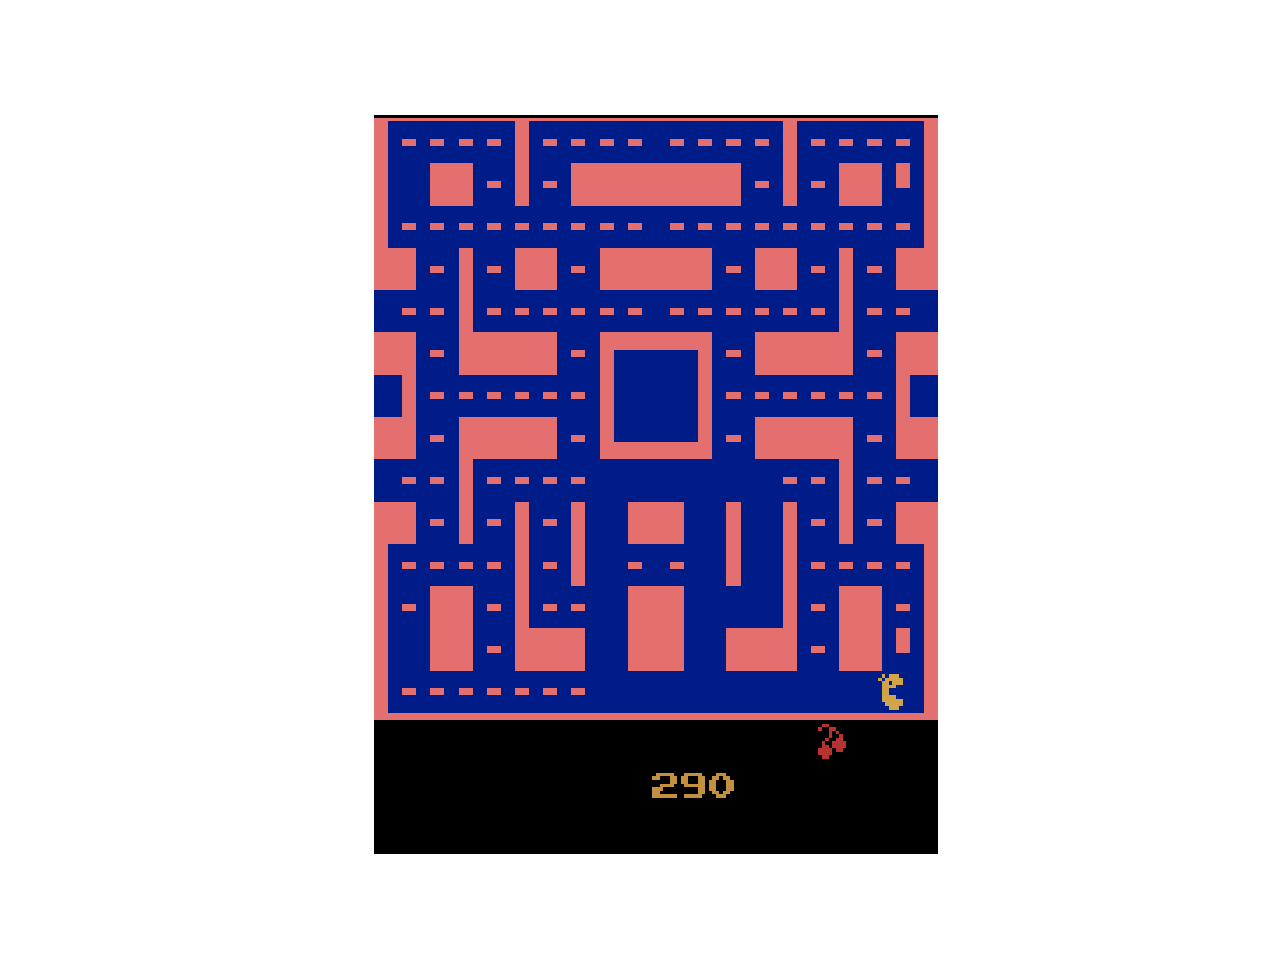

In [92]:
plot_animation(frames)

# Extra material

## Preprocessing for Breakout

Here is a preprocessing function you can use to train a DQN for the Breakout-v0 Atari game:

In [ ]:
def preprocess_observation(obs):
    img = obs[34:194:2, ::2] # crop and downsize
    return np.mean(img, axis=2).reshape(80, 80) / 255.0

In [ ]:
env = gym.make("Breakout-v0")
obs = env.reset()
for step in range(10):
    obs, _, _, _ = env.step(1)

img = preprocess_observation(obs)

In [ ]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Original observation (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("Preprocessed observation (80×80 grayscale)")
plt.imshow(img, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

As you can see, a single image does not give you the direction and speed of the ball, which are crucial informations for playing this game. For this reason, it is best to actually combine several consecutive observations to create the environment's state representation. One way to do that is to create a multi-channel image, with one channel per recent observation. Another is to merge all recent observations into a single-channel image, using `np.max()`. In this case, we need to dim the older images so that the DQN can distinguish the past from the present.

In [ ]:
from collections import deque

def combine_observations_multichannel(preprocessed_observations):
    return np.array(preprocessed_observations).transpose([1, 2, 0])

def combine_observations_singlechannel(preprocessed_observations, dim_factor=0.5):
    dimmed_observations = [obs * dim_factor**index
                           for index, obs in enumerate(reversed(preprocessed_observations))]
    return np.max(np.array(dimmed_observations), axis=0)

n_observations_per_state = 3
preprocessed_observations = deque([], maxlen=n_observations_per_state)

obs = env.reset()
for step in range(10):
    obs, _, _, _ = env.step(1)
    preprocessed_observations.append(preprocess_observation(obs))

In [ ]:
img1 = combine_observations_multichannel(preprocessed_observations)
img2 = combine_observations_singlechannel(preprocessed_observations)

plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title("Multichannel state")
plt.imshow(img1, interpolation="nearest")
plt.axis("off")
plt.subplot(122)
plt.title("Singlechannel state")
plt.imshow(img2, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

# Exercise solutions

## 1. to 7.

See Appendix A.

## 8. BipedalWalker-v2

Exercise: _Use policy gradients to tackle OpenAI gym's "BipedalWalker-v2"._

In [ ]:
import gym

In [ ]:
env = gym.make("BipedalWalker-v2")

Note: if you run into [this issue](https://github.com/openai/gym/issues/100) ("`module 'Box2D._Box2D' has no attribute 'RAND_LIMIT'`") when making the `BipedalWalker-v2` environment, then try this workaround:

```
$ pip uninstall Box2D-kengz
$ pip install git+https://github.com/pybox2d/pybox2d
```

In [ ]:
obs = env.reset()

In [ ]:
img = env.render(mode="rgb_array")

In [ ]:
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
obs

You can find the meaning of each of these 24 numbers in the [documentation](https://github.com/openai/gym/wiki/BipedalWalker-v2).

In [ ]:
env.action_space

In [ ]:
env.action_space.low

In [ ]:
env.action_space.high

This is a 4D continuous action space controling each leg's hip torque and knee torque (from -1 to 1). To deal with a continuous action space, one method is to discretize it. For example, let's limit the possible torque values to these 3 values: -1.0, 0.0, and 1.0. This means that we are left with $3^4=81$ possible actions.

In [ ]:
from itertools import product

In [ ]:
possible_torques = np.array([-1.0, 0.0, 1.0])
possible_actions = np.array(list(product(possible_torques, possible_torques, possible_torques, possible_torques)))
possible_actions.shape

In [ ]:
tf.reset_default_graph()

# 1. Specify the network architecture
n_inputs = env.observation_space.shape[0]  # == 24
n_hidden = 10
n_outputs = len(possible_actions) # == 625
initializer = tf.variance_scaling_initializer()

# 2. Build the neural network
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.selu,
                         kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs,
                         kernel_initializer=initializer)
outputs = tf.nn.softmax(logits)

# 3. Select a random action based on the estimated probabilities
action_index = tf.squeeze(tf.multinomial(logits, num_samples=1), axis=-1)

# 4. Training
learning_rate = 0.01

y = tf.one_hot(action_index, depth=len(possible_actions))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's try running this policy network, although it is not trained yet.

In [ ]:
def run_bipedal_walker(model_path=None, n_max_steps = 1000):
    env = gym.make("BipedalWalker-v2")
    frames = []
    with tf.Session() as sess:
        if model_path is None:
            init.run()
        else:
            saver.restore(sess, model_path)
        obs = env.reset()
        for step in range(n_max_steps):
            img = env.render(mode="rgb_array")
            frames.append(img)
            action_index_val = action_index.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            action = possible_actions[action_index_val]
            obs, reward, done, info = env.step(action[0])
            if done:
                break
    env.close()
    return frames

In [ ]:
frames = run_bipedal_walker()
video = plot_animation(frames)
plt.show()

Nope, it really can't walk. So let's train it!

In [ ]:
n_games_per_update = 10
n_max_steps = 1000
n_iterations = 1000
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}/{}".format(iteration + 1, n_iterations), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_index_val, gradients_val = sess.run([action_index, gradients],
                                                           feed_dict={X: obs.reshape(1, n_inputs)})
                action = possible_actions[action_index_val]
                obs, reward, done, info = env.step(action[0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_bipedal_walker_pg.ckpt")

In [ ]:
frames = run_bipedal_walker("./my_bipedal_walker_pg.ckpt")
video = plot_animation(frames)
plt.show()

Not the best walker, but at least it stays up and makes (slow) progress to the right.
A better solution for this problem is to use an actor-critic algorithm, as it does not require discretizing the action space, and it converges much faster. Check out this nice [blog post](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-actor-critic-models-f084612cfd69) by Yash Patel for more details.

## 9.

**Coming soon**